# Feature Engineering Notebook

## Objectives

* Engineer features for a Regression Model

## Inputs

* `outputs/datasets/cleaned/TrainSetCleaned.csv`
* `outputs/datasets/cleaned/TestSetCleaned.csv`

## Outputs

* Generate a list of variables to engineer

## Conclusions

* Feature Engineering Transformers
  * Ordinal Categorical Encoding: `['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']`
  * Outlier Winsorizer: `['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF']`
  * Numerical Transformation:
    * Log Transformer (10): `['1stFlrSF', 'GrLivArea', 'LotFrontage']` 
    * Power Transformer: `['BsmtUnfSF']`
    * Yeo Johnson Transformer: `['GarageArea','TotalBsmtSF']`
    * Box Cox Transformer: `['LotArea']`
  * Smart Correlated Selection: `All Features`

---

# Import all modules required in the workbook

In [1]:
import os
import pandas as pd
from ydata_profiling import ProfileReport

import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

from sklearn.pipeline import Pipeline

sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

# Change working directory

The notebooks for this project are stored in a subfolder called `jupyter_notebooks`, therefore when running the notebook, the working directory needs to be changed to the parent folder. 
* We access the current directory with `os.getcwd()`

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/pp5-house-price-predictor/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory of: ", os.getcwd())

You set a new current directory of:  /workspace/pp5-house-price-predictor


---

# Load Cleaned Data

Train Set

In [4]:
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      1828       0.0      2.883272           Av          48          Unf   
1       894       0.0      2.000000           No           0          Unf   
2       964       0.0      2.000000           No         713          ALQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0       1774         774          Unf       2007.0  ...    11694        90.0   
1        894         308          Unf       1962.0  ...     6600        60.0   
2        163         432          Unf       1921.0  ...    13360        80.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0       452.0          108            5            9         1822       2007   
1         0.0            0            5            5          894       1962   
2         0.0            0            7            5          876       1921   

   YearRemodAdd  SalePrice  
0          2007     314813  
1          1962     109500  
2          2006     163500  

[3 rows x 22 columns]

Test Set

In [5]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      2515       0.0           4.0           No        1219          Rec   
1       958     620.0           3.0           No         403          BLQ   
2       979     224.0           3.0           No         185          LwQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0        816         484          Unf       1975.0  ...    32668        70.0   
1        238         240          Unf       1941.0  ...     9490        79.0   
2        524         352          Unf       1950.0  ...     7015        70.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0         0.0            0            3            6         2035       1957   
1         0.0            0            7            6          806       1941   
2       161.0            0            4            5          709       1950   

   YearRemodAdd  SalePrice  
0          1975     200624  
1          1950     133000  
2          1950     110000  

[3 rows x 22 columns]

# Data Exploration

Revisit the ProfileReport to asses which transformations could be performed on the variables

In [6]:
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Feature Engineering

## Custom Function

The custom function below was provided by CI as part of the walkthrough projects and LMS lessons.

In [7]:
def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            "There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

## Dealing with Feature Engineering

The variables look like they can be grouped in to categories, as per below. Which will help define whether they need encoding or not, and help state the reasons why. 

- **Target (1)**
  - `['SalePrice']`
- **Dropped (2)**
  - `['EnclosedPorch', 'WoodDeckSF']`
- **Quality/Ordinal related variables (7)**
  - Already encoded (3)
    - `['BedroomAbvGr', 'OverallCond', 'OverallQual']`
  - Not encoded (4)
    - `['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']`
- **Area related variables (11)**
  - `['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF','GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF']`
- **Year related variables (3)**
  - `['GarageYrBlt', 'YearBuilt', 'YearRemodAdd']`

* All variables in the Area Related group warrant a review for outliers and I will use the outlier trimmer of winsorization to review the effect on these features. 
* Also I will run each variable through the SmartCorrelatedSelection transformer to determine which features can be dropped due to their correlation to each other. 

### Categorical Encoding - Ordinal

Step 1: Select the variable(s)

In [8]:
variables_engineering = ['BsmtExposure', 'BsmtFinType1',
                         'GarageFinish', 'KitchenQual']
variables_engineering

['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

Step 2: Create a separate DataFrame with the selected variable(s)

In [9]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

BsmtExposure BsmtFinType1 GarageFinish KitchenQual
0           Av          Unf          Unf          Gd
1           No          Unf          Unf          TA
2           No          ALQ          Unf          TA

Step 3: Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method for each variable.

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



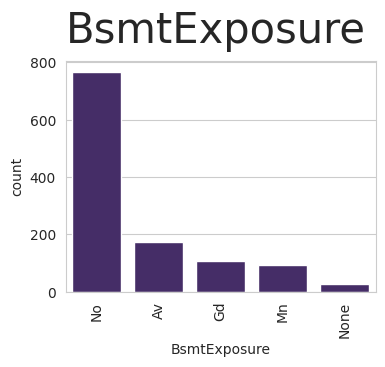

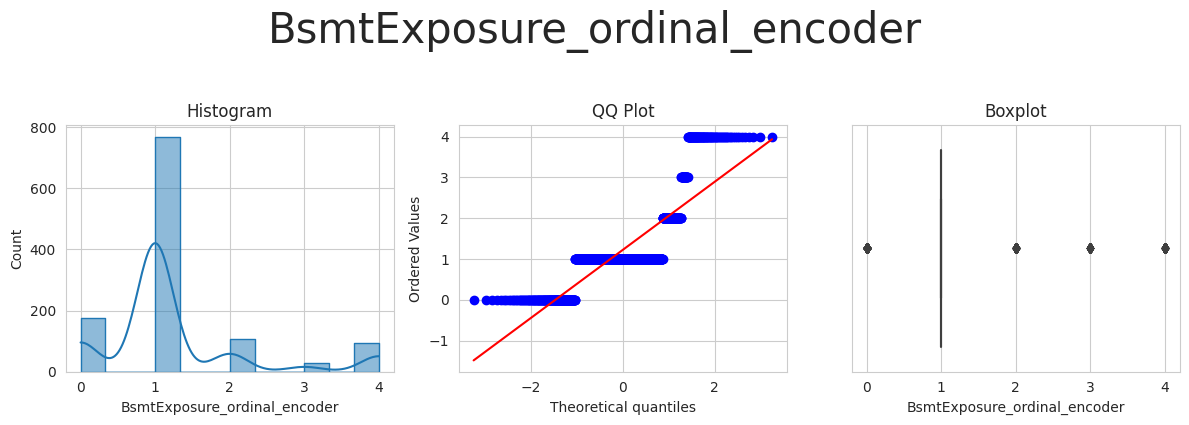



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



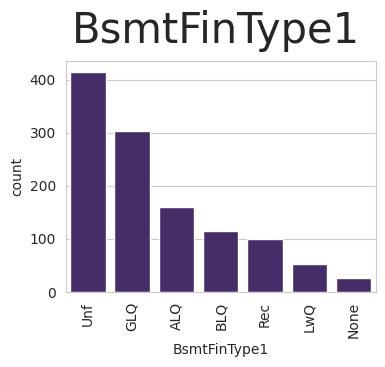

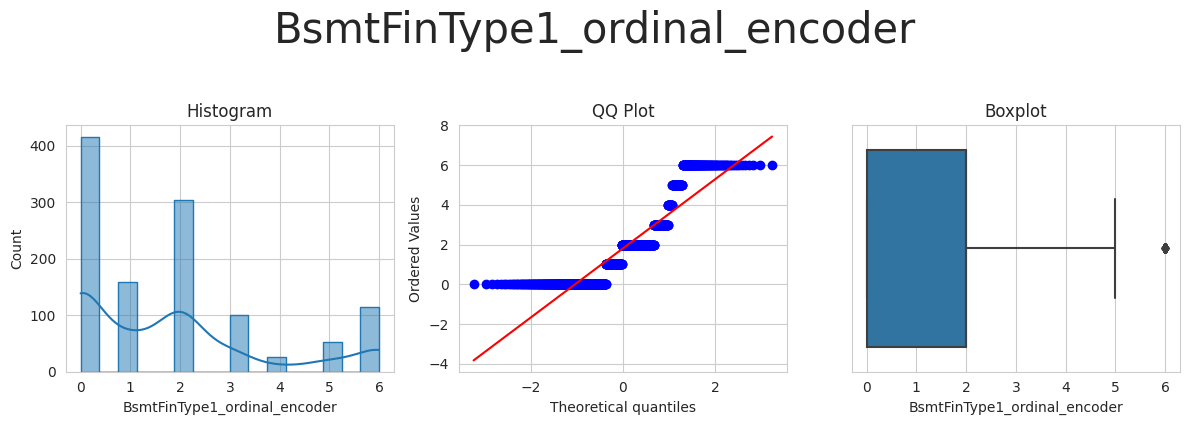



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



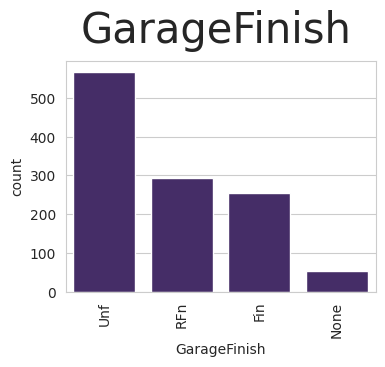

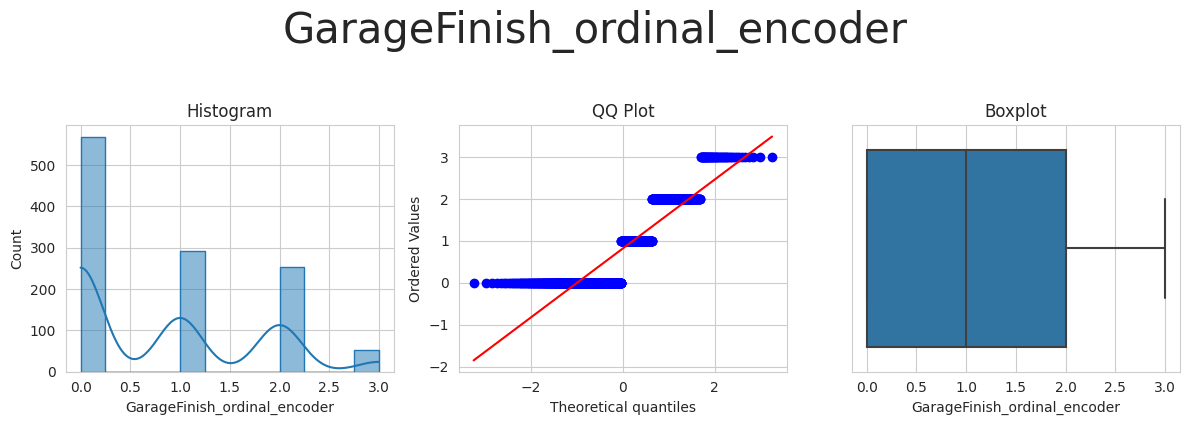



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



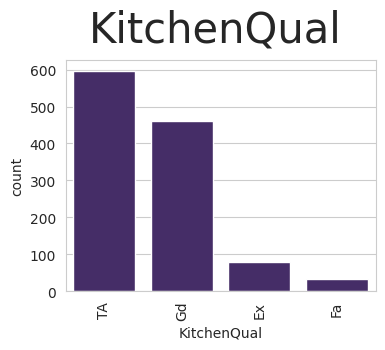

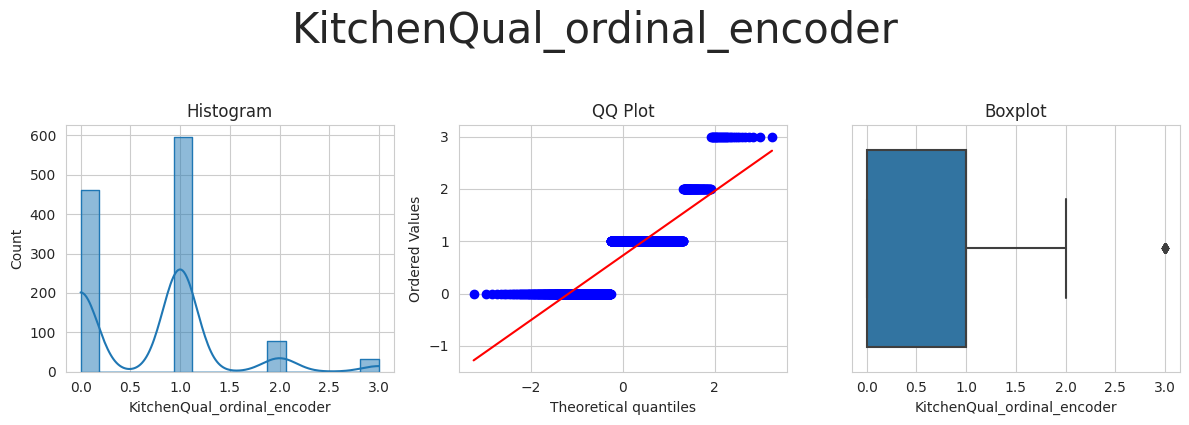

In [10]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering,
                                            analysis_type='ordinal_encoder')

Conclusion: Transformations look good so happy to commit to these on the data set. 

Step 4: Apply the selected transformations to the Train and Test set

In [11]:
# This is completed at the bottom of the workbook in one pipeline

### Outliers

I will run all numerical variables related to area through the winsorisation function as most features have exhibited observations of outliers within the data. 

Step 1: Select the variable(s)

In [12]:
variables_engineering = ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1',
                         'BsmtUnfSF', 'GarageArea', 'GrLivArea',
                         'LotArea', 'LotFrontage', 'MasVnrArea',
                         'OpenPorchSF', 'TotalBsmtSF']

Step 2: Create a separate DataFrame with the selected variable(s)

In [13]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

1stFlrSF  2ndFlrSF  BsmtFinSF1  BsmtUnfSF  GarageArea  GrLivArea  LotArea  \
0      1828       0.0          48       1774         774       1828    11694   
1       894       0.0           0        894         308        894     6600   
2       964       0.0         713        163         432        964    13360   

   LotFrontage  MasVnrArea  OpenPorchSF  TotalBsmtSF  
0         90.0       452.0          108         1822  
1         60.0         0.0            0          894  
2         80.0         0.0            0          876

Step 3: Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method for each variable.

* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_iqr'] 



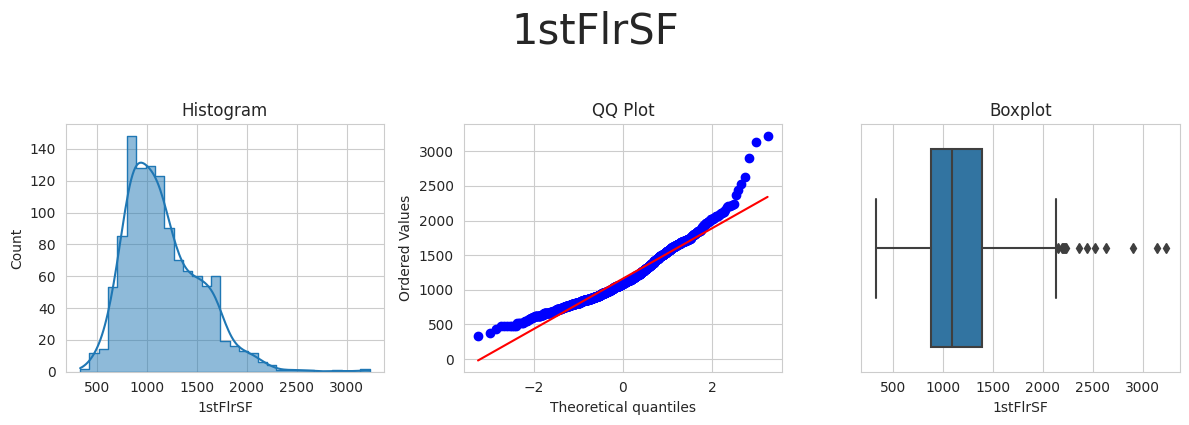

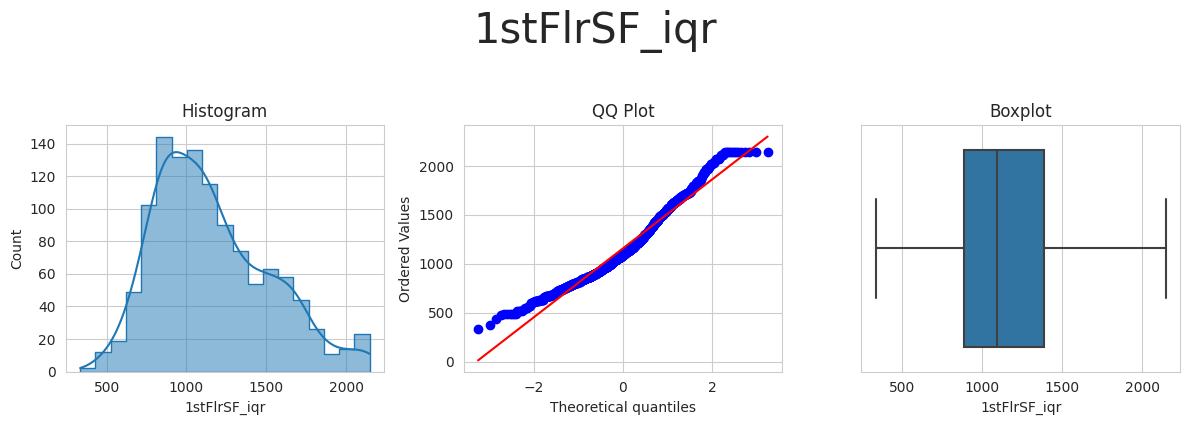



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_iqr'] 



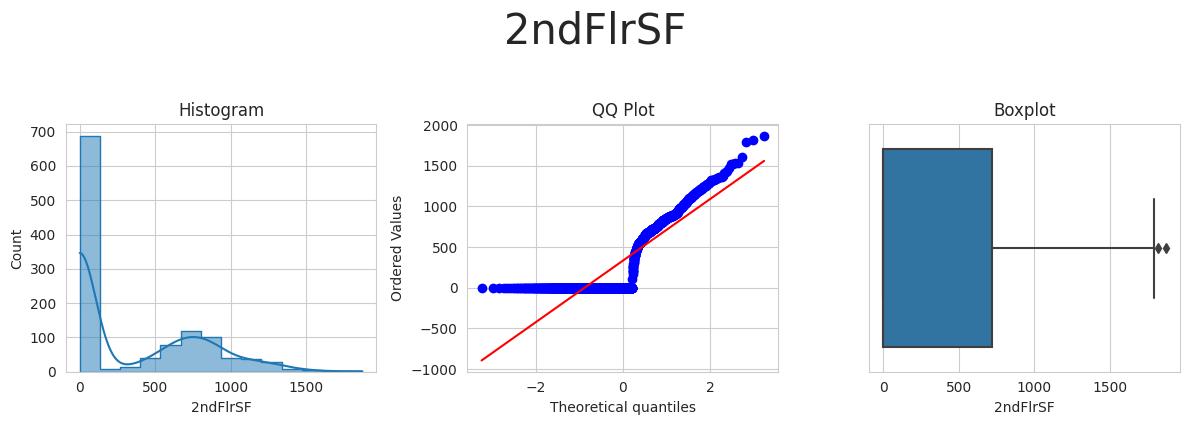

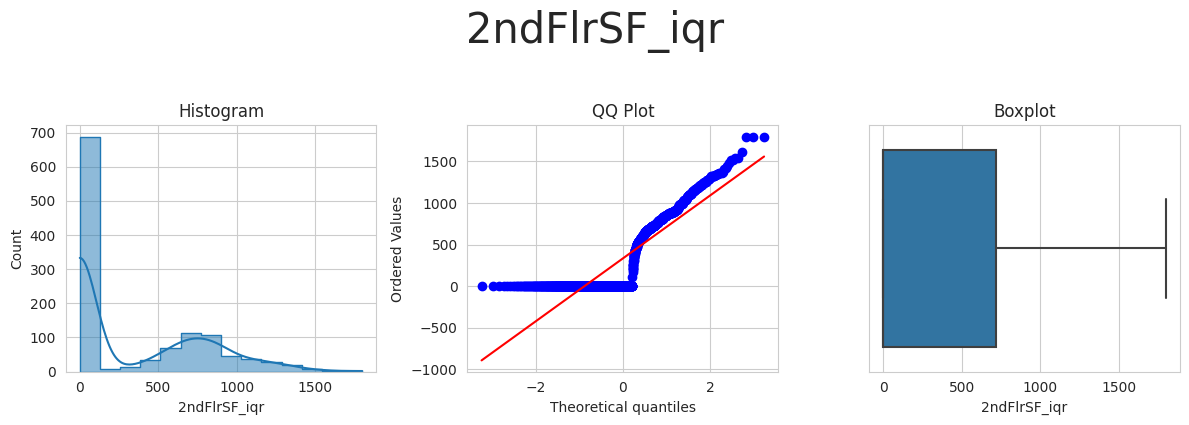



* Variable Analyzed: BsmtFinSF1
* Applied transformation: ['BsmtFinSF1_iqr'] 



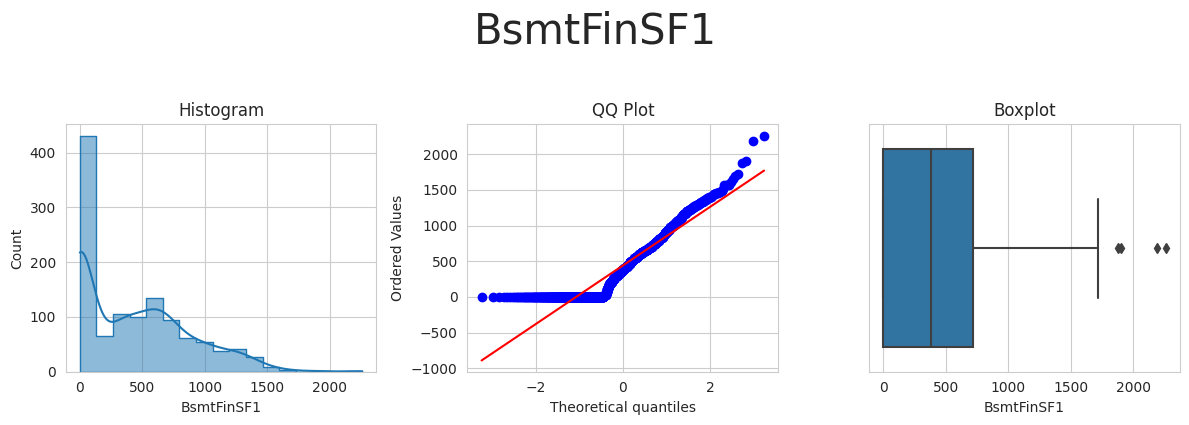

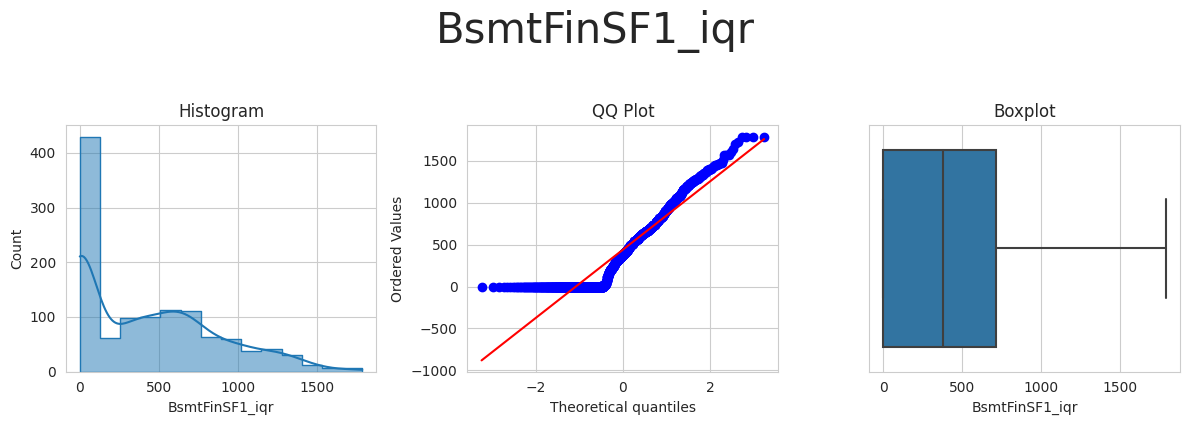



* Variable Analyzed: BsmtUnfSF
* Applied transformation: ['BsmtUnfSF_iqr'] 



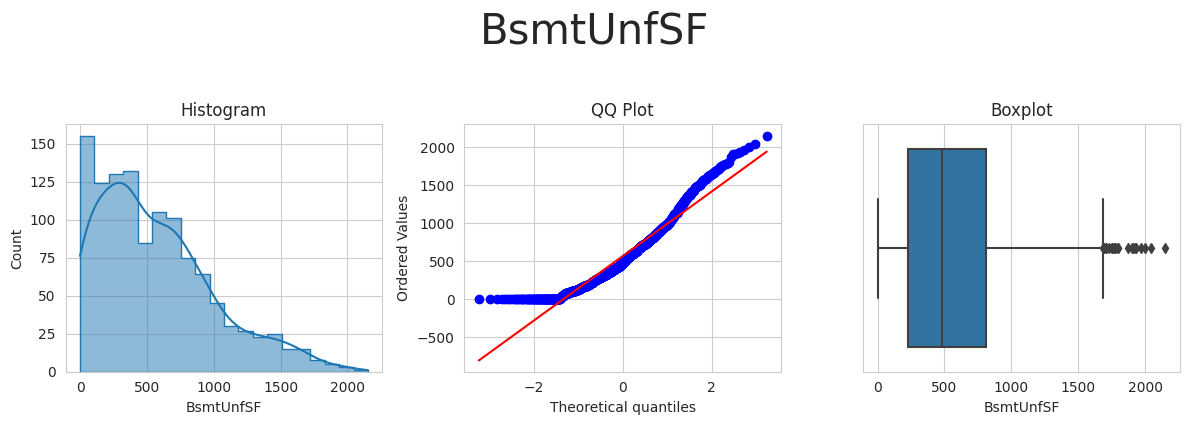

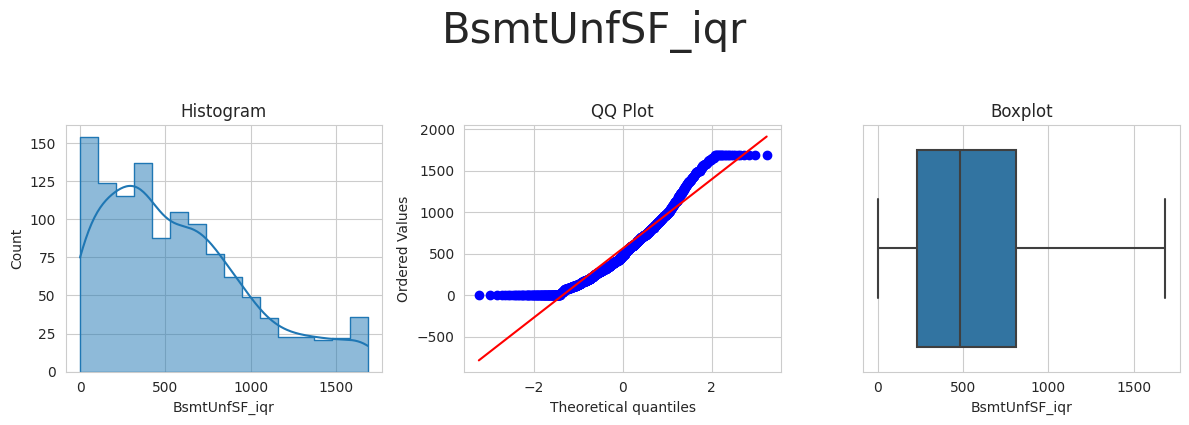



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_iqr'] 



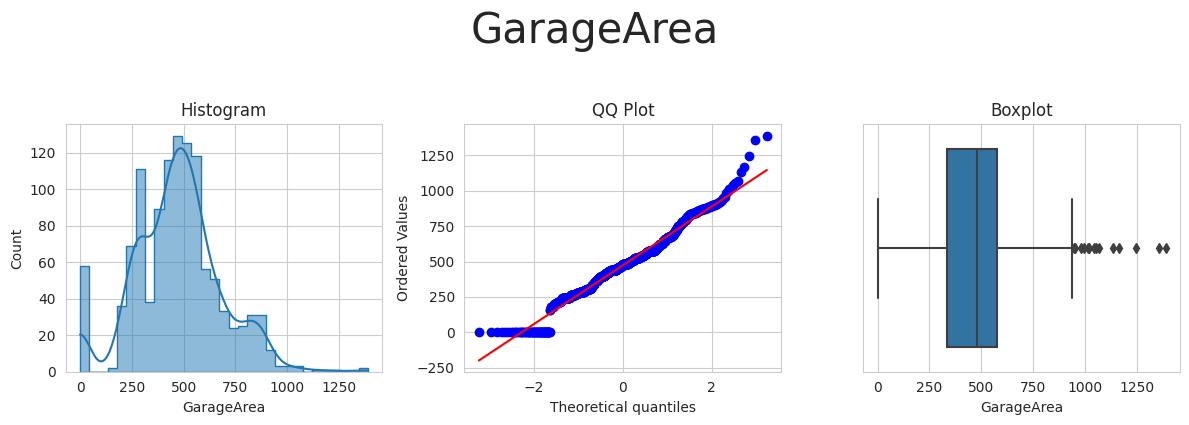

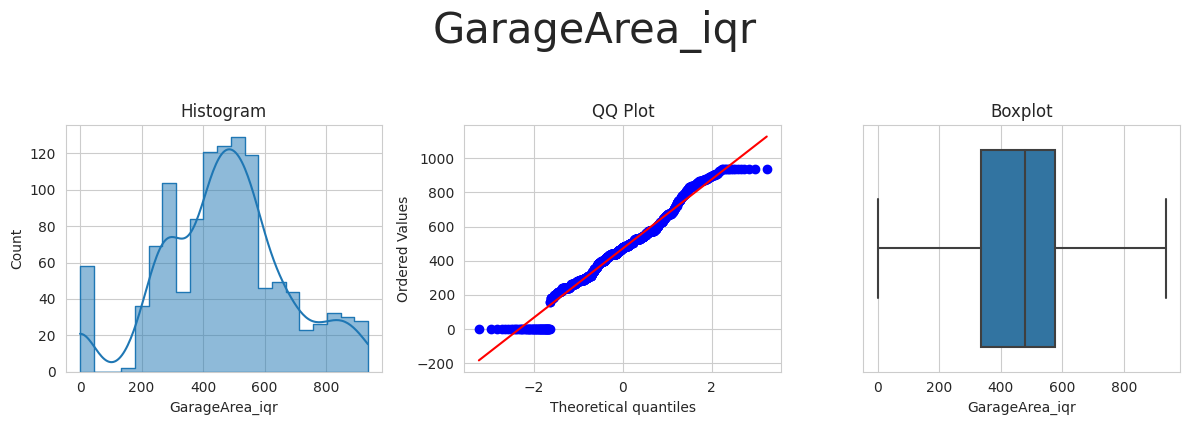



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_iqr'] 



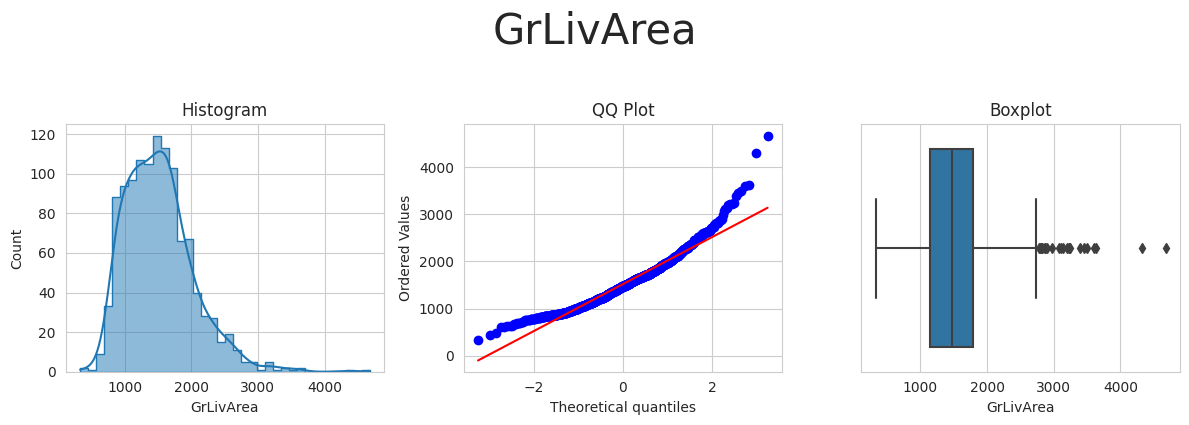

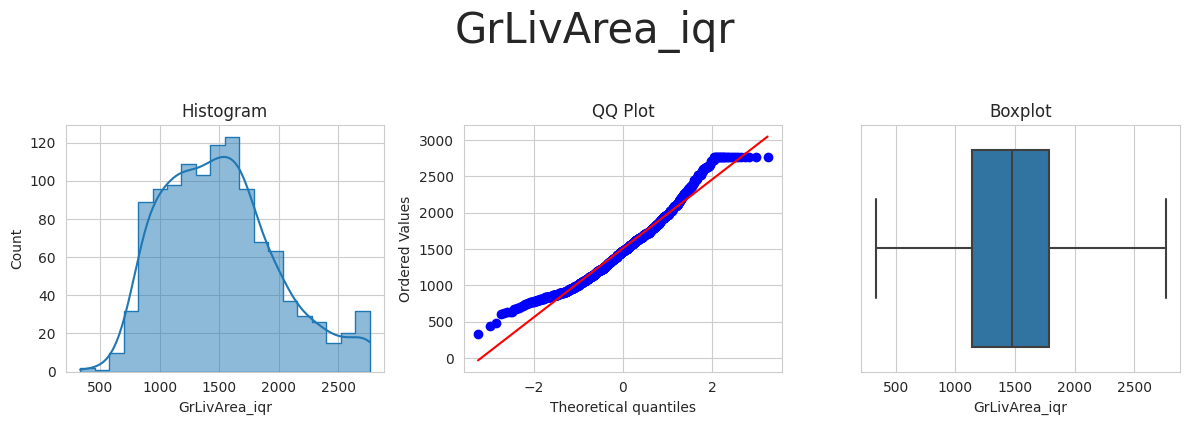



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_iqr'] 



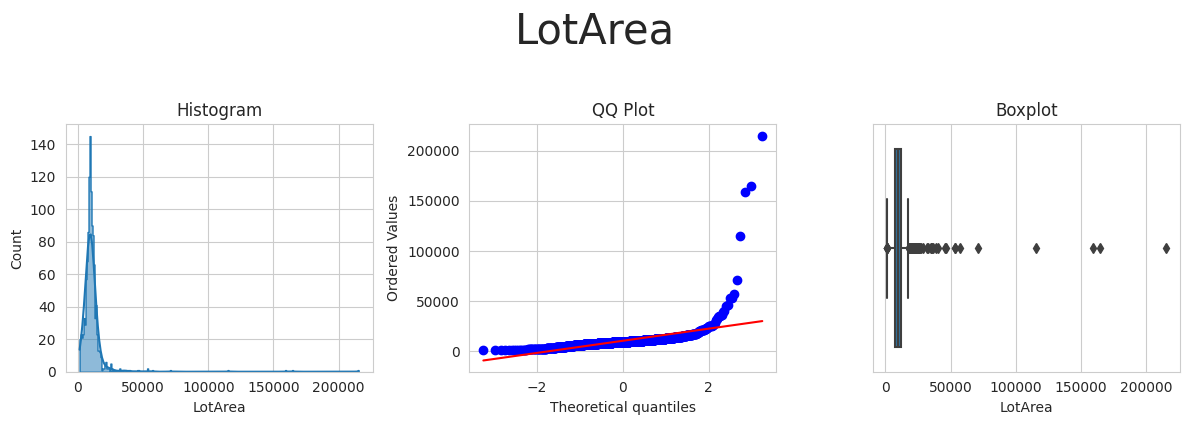

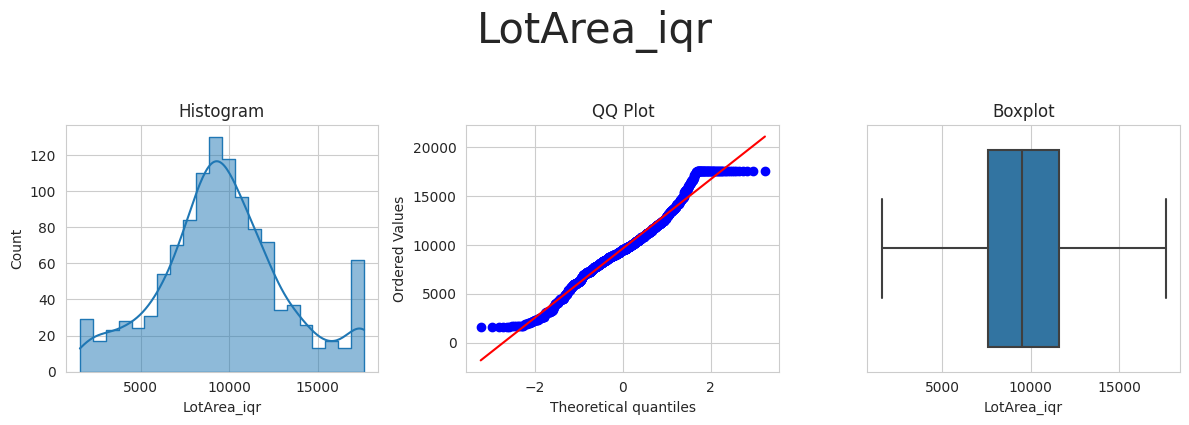



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_iqr'] 



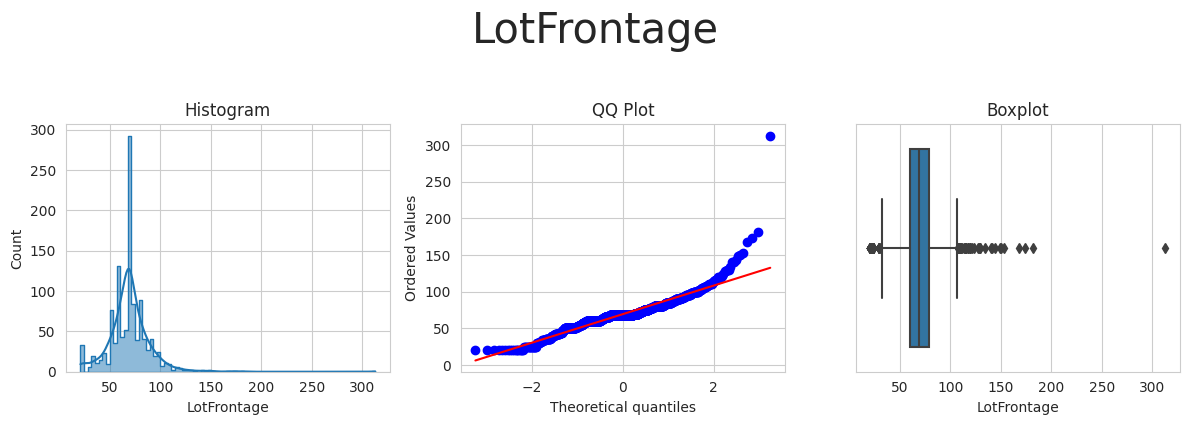

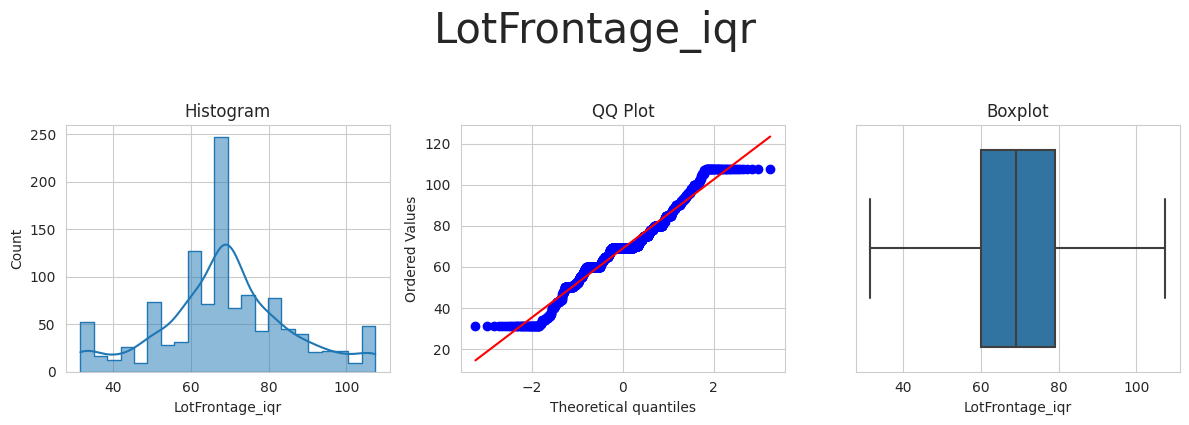



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_iqr'] 



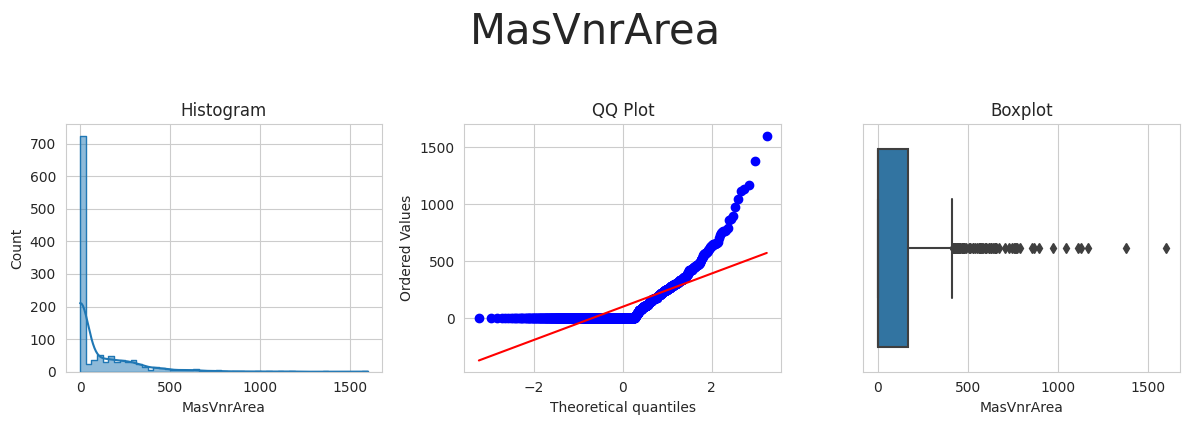

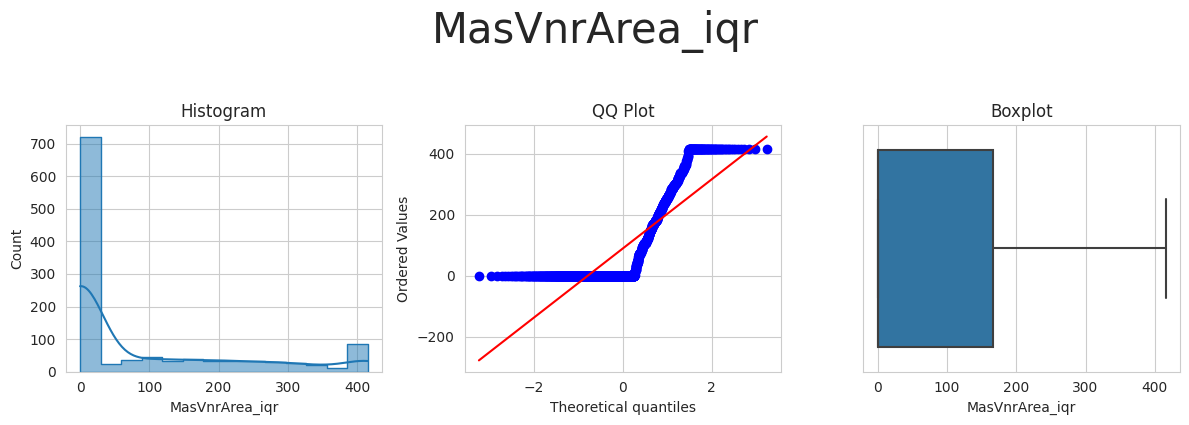



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_iqr'] 



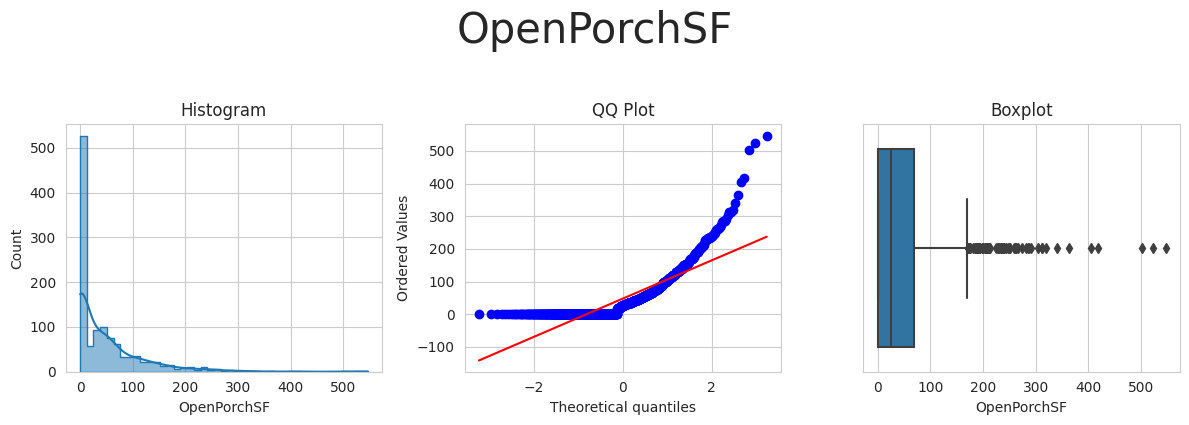

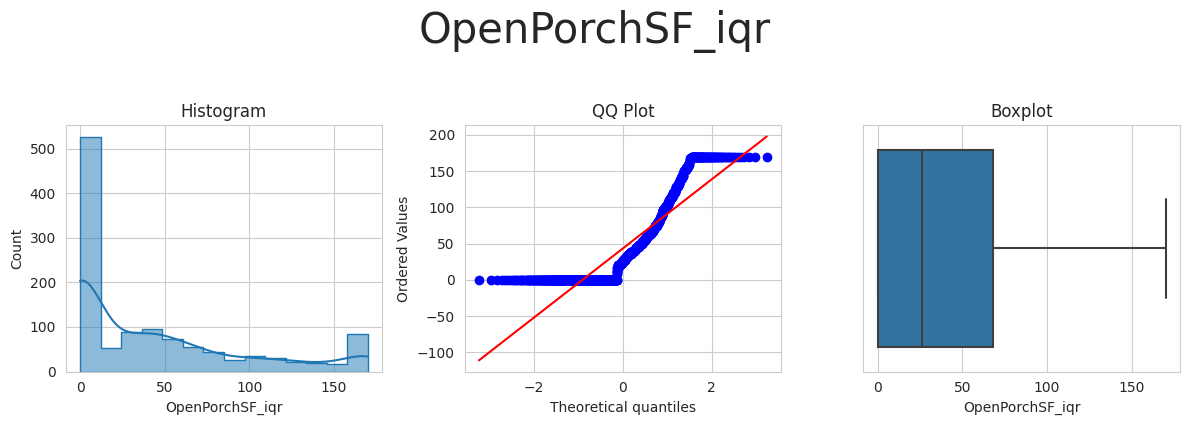



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_iqr'] 



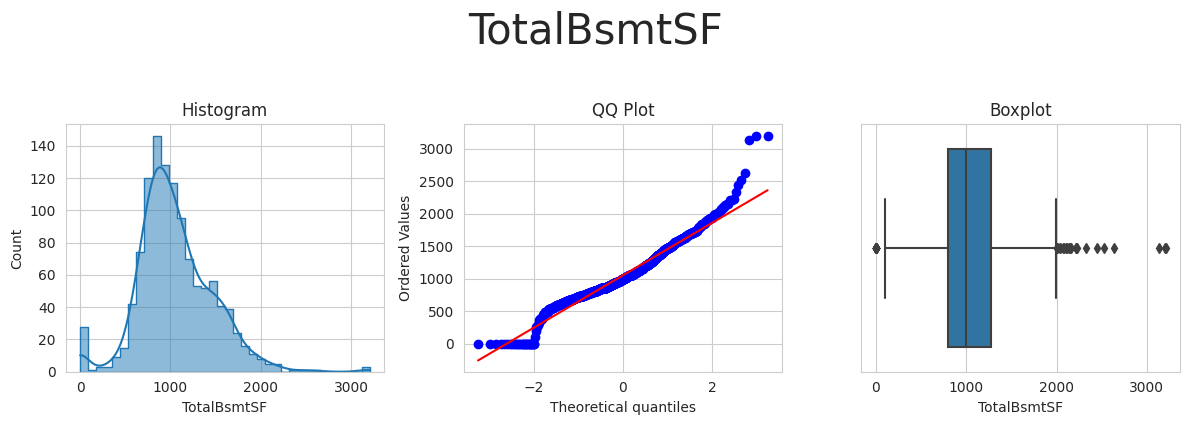

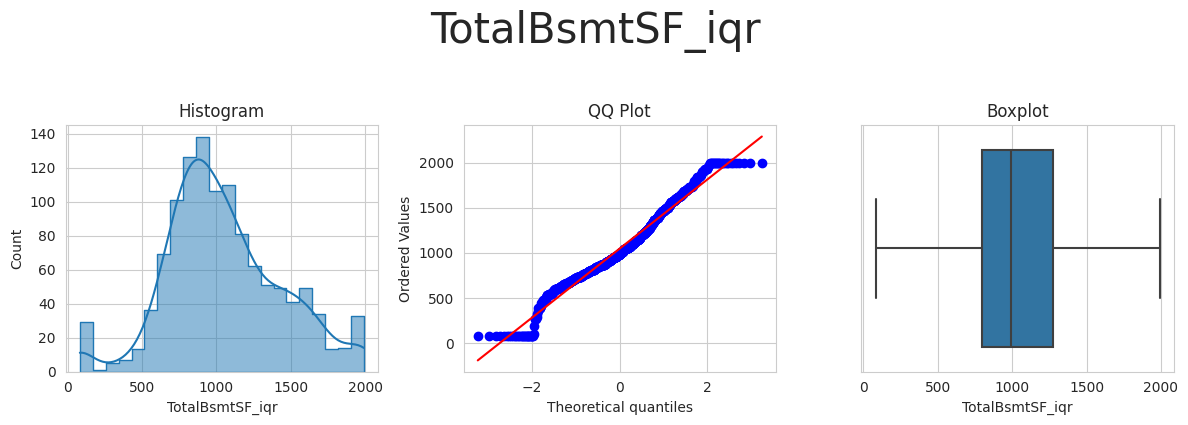

In [14]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering,
                                            analysis_type='outlier_winsorizer')

Conclusion: I will apply the winsorization function to all of the variables related to area in the ML pipeline due to the outliers all being reduced/removed. We can test applying this before numerical transformations or after transformations when working through the full modelling of the ML pipeline in the next notebook.

Step 4: Apply the selected transformation to the Train and Test set

In [15]:
# This is completed at the bottom of the workbook in one pipeline

### Numerical Tranformation

I will run an assessment of the most appropriate transformer on the area related variables and not the year related variables as a transformer on the year would not make sense to perform as most have a close mean and median and limited kurtosis and skewness.

I will continue below on the area related variables only. 



Step 1: Select the variable(s)

In [16]:
variables_engineering = ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF',
                         'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage',
                         'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF']

Step 2: Create a separate DataFrame with the selected variable(s)

In [17]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

1stFlrSF  2ndFlrSF  BsmtFinSF1  BsmtUnfSF  GarageArea  GrLivArea  LotArea  \
0      1828       0.0          48       1774         774       1828    11694   
1       894       0.0           0        894         308        894     6600   
2       964       0.0         713        163         432        964    13360   

   LotFrontage  MasVnrArea  OpenPorchSF  TotalBsmtSF  
0         90.0       452.0          108         1822  
1         60.0         0.0            0          894  
2         80.0         0.0            0          876

Step 3: Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method for each variable.

* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



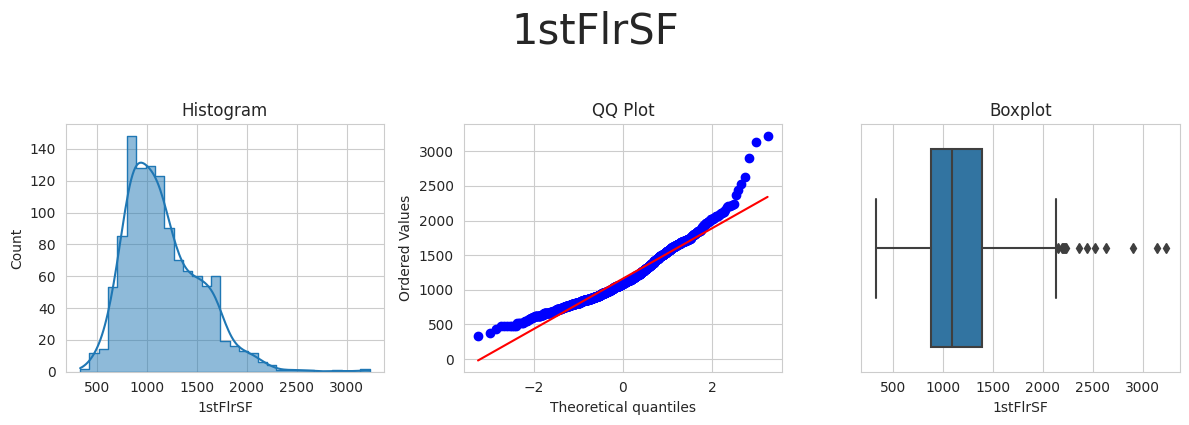

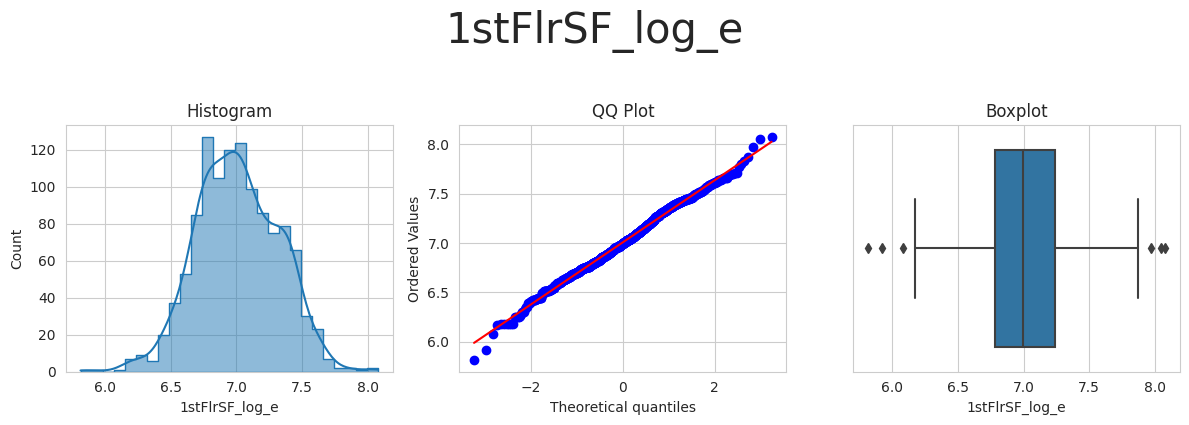

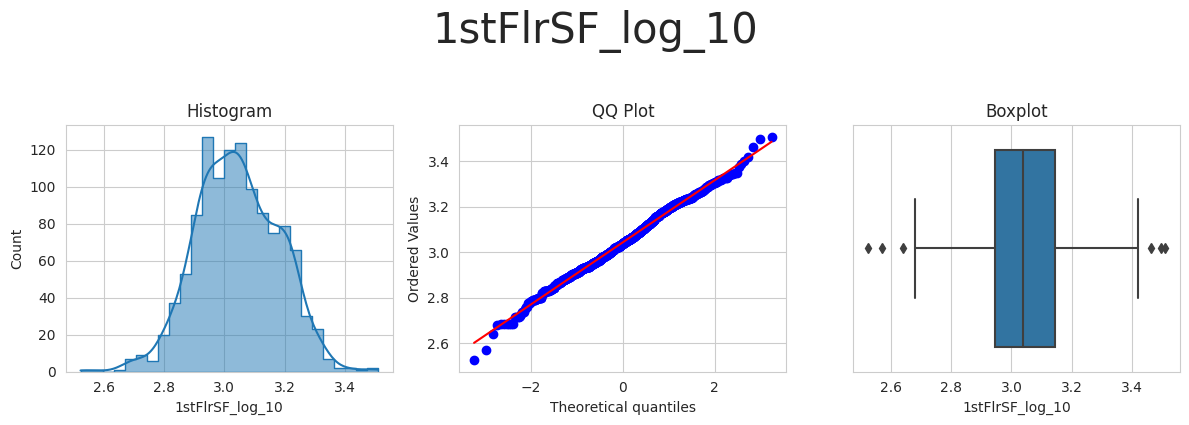

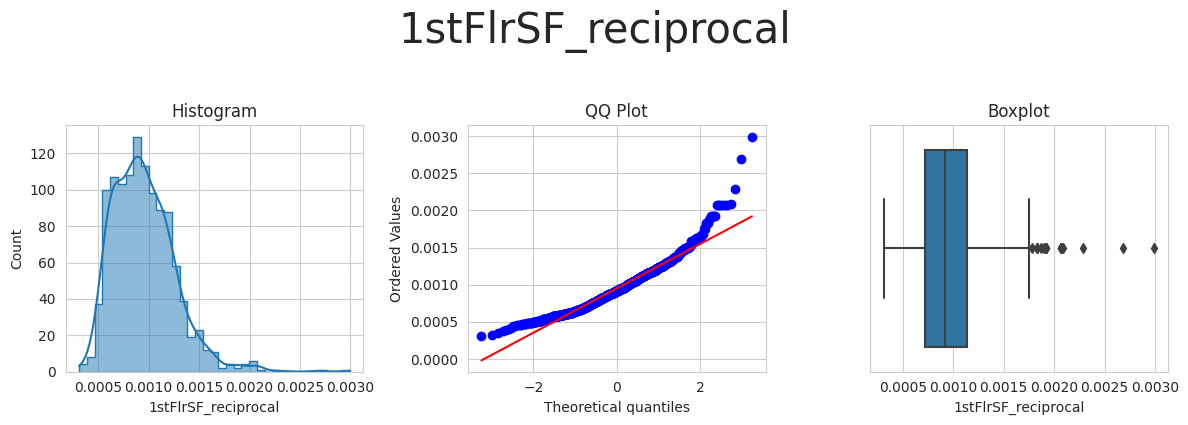

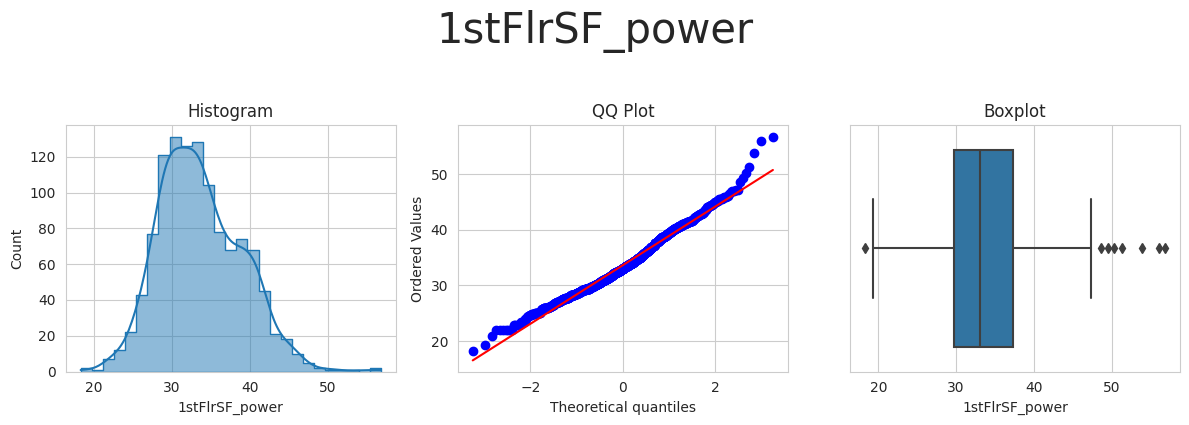

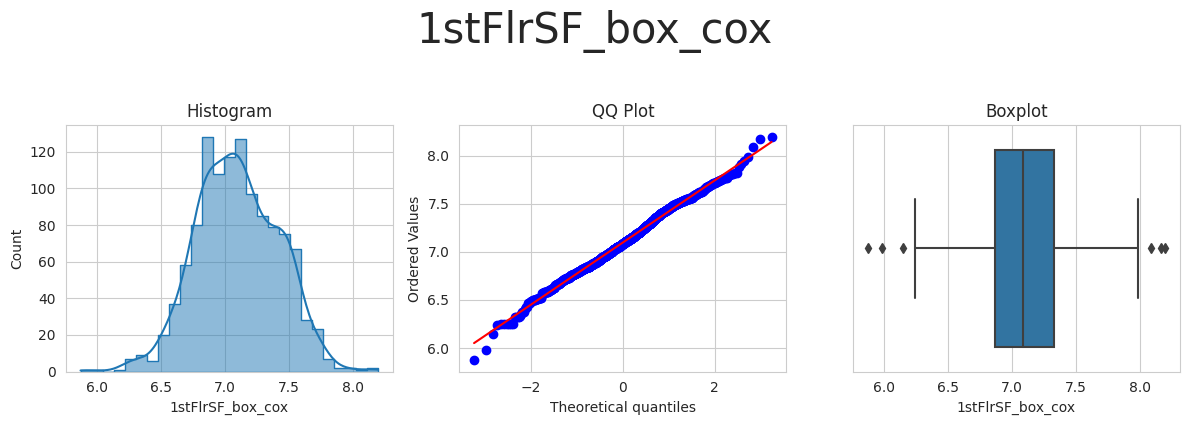

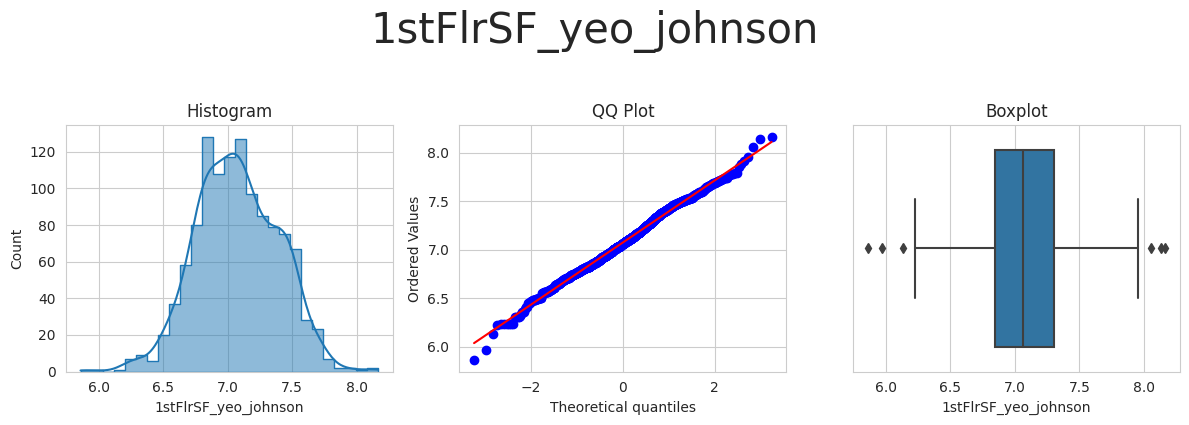



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 



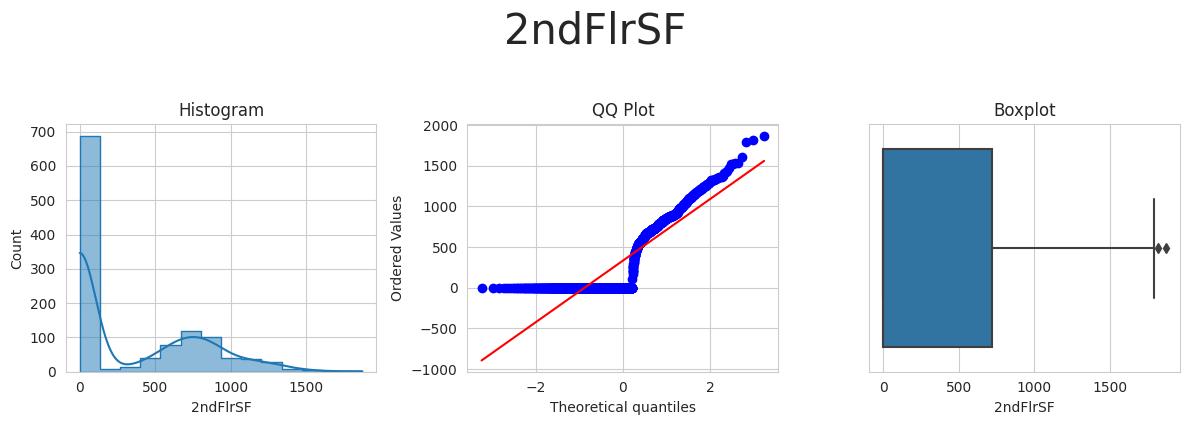

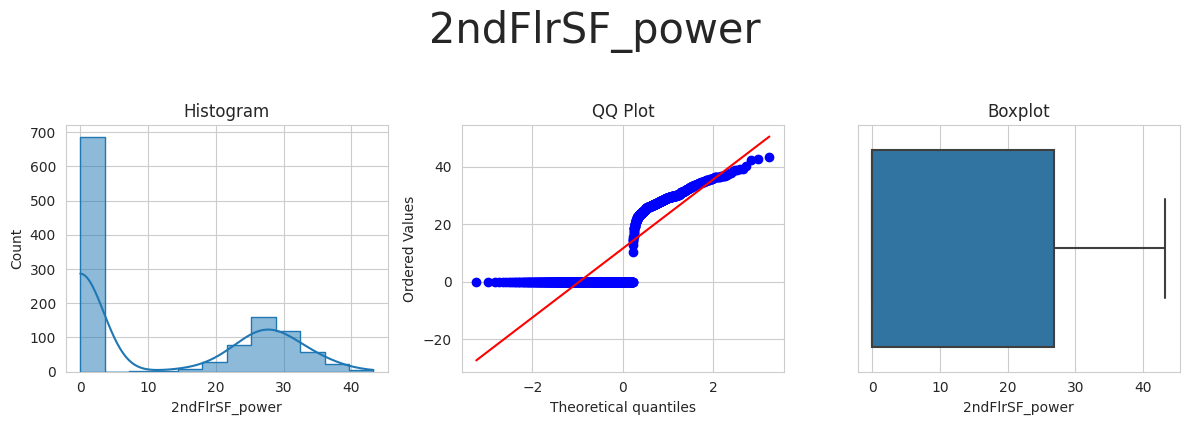

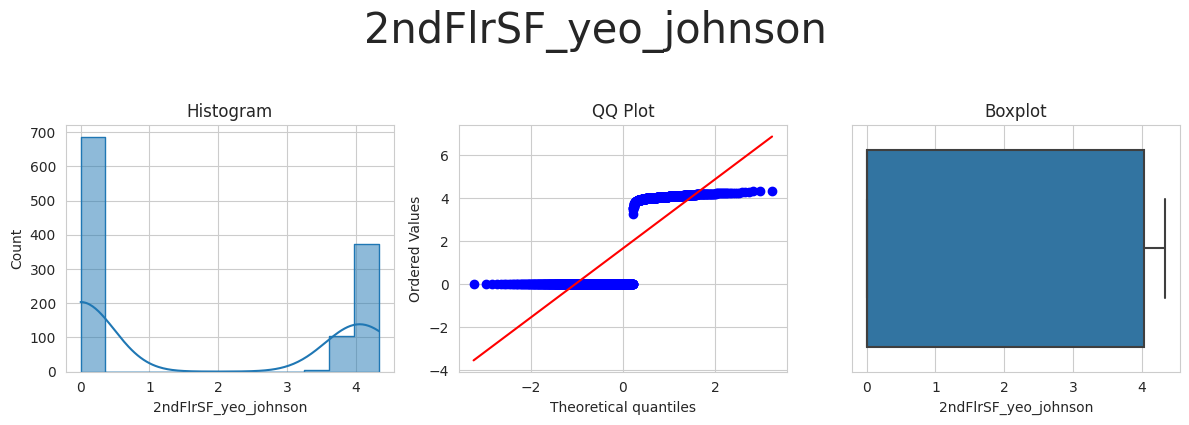



* Variable Analyzed: BsmtFinSF1
* Applied transformation: ['BsmtFinSF1_power', 'BsmtFinSF1_yeo_johnson'] 



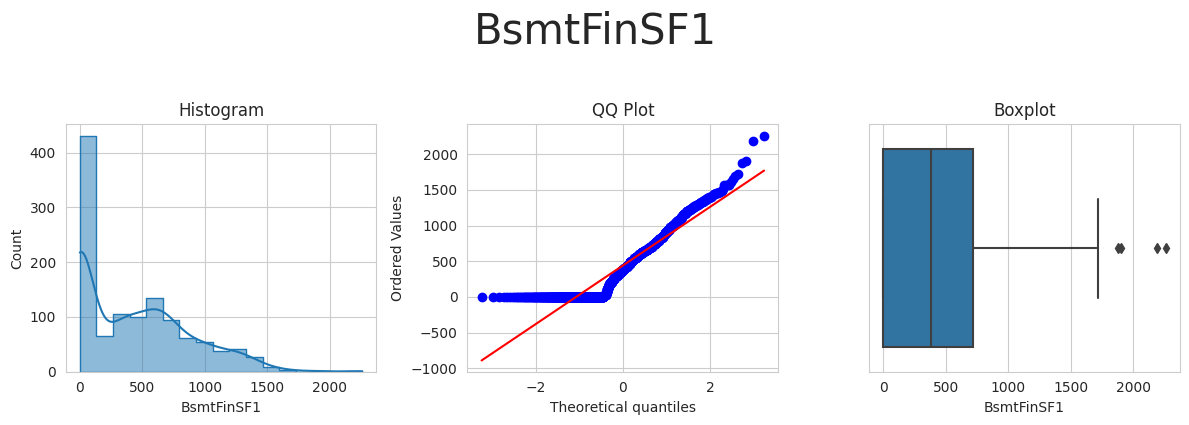

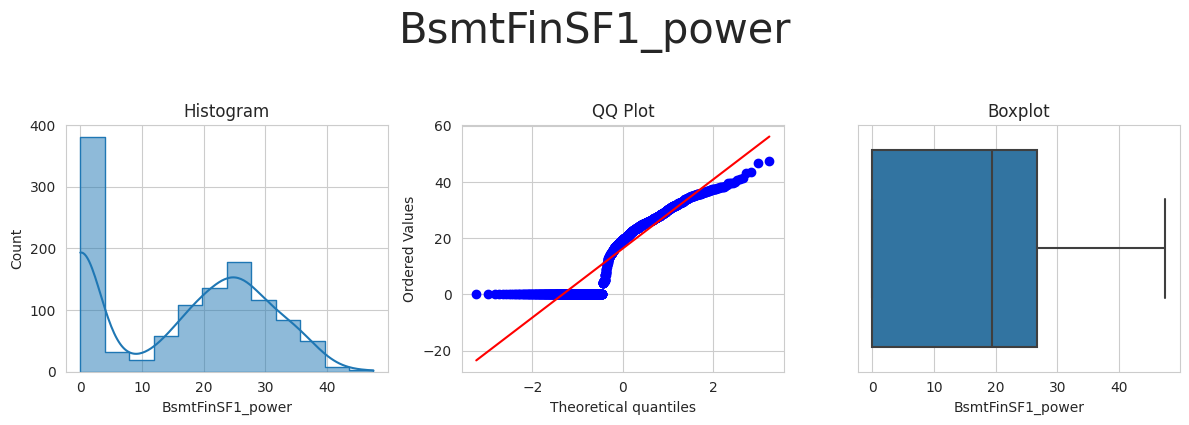

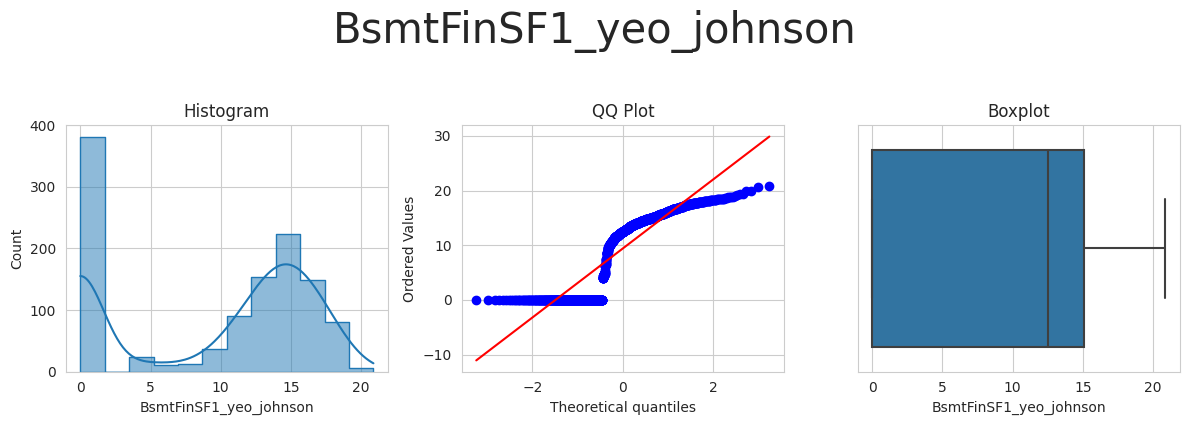



* Variable Analyzed: BsmtUnfSF
* Applied transformation: ['BsmtUnfSF_power', 'BsmtUnfSF_yeo_johnson'] 



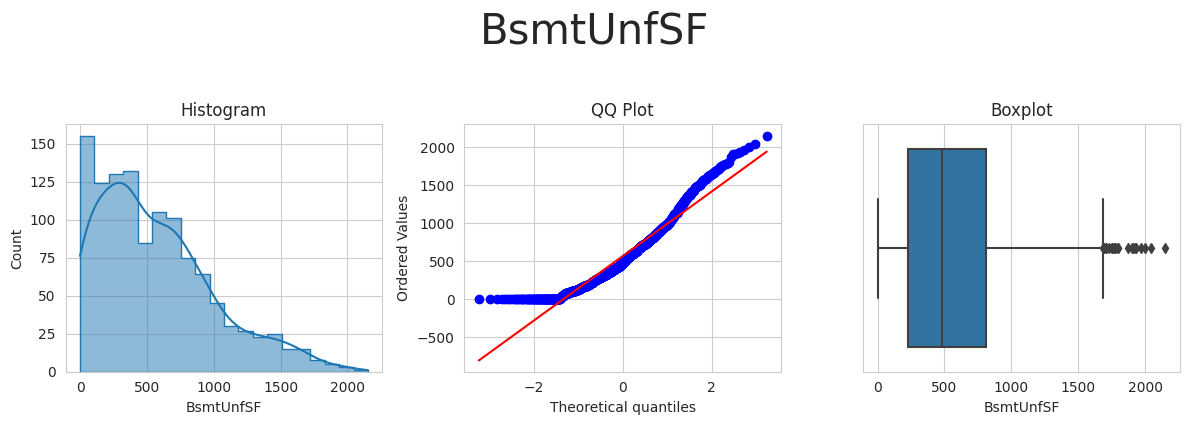

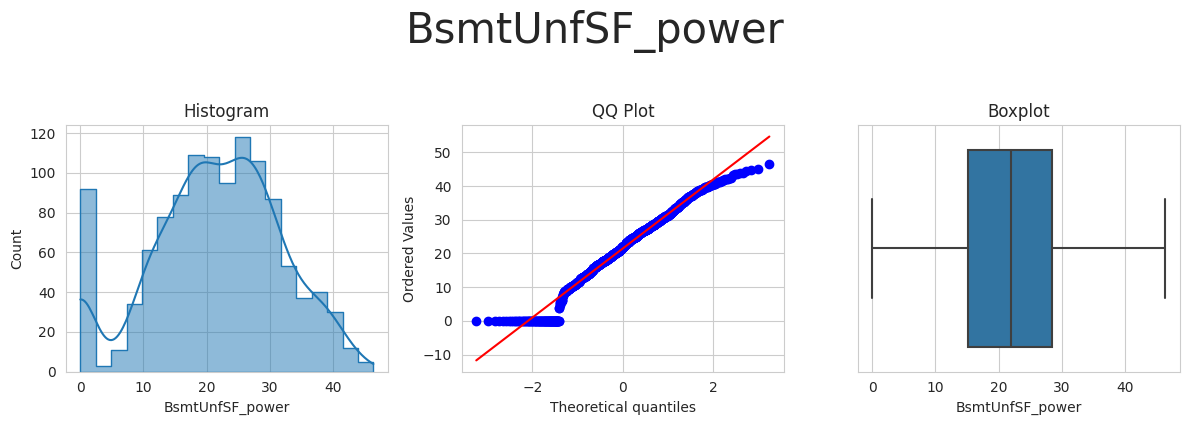

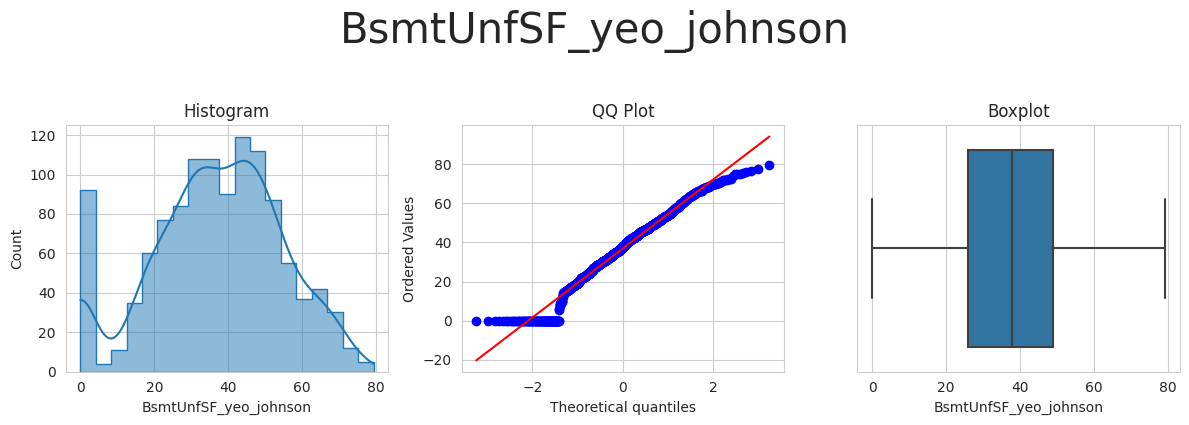



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



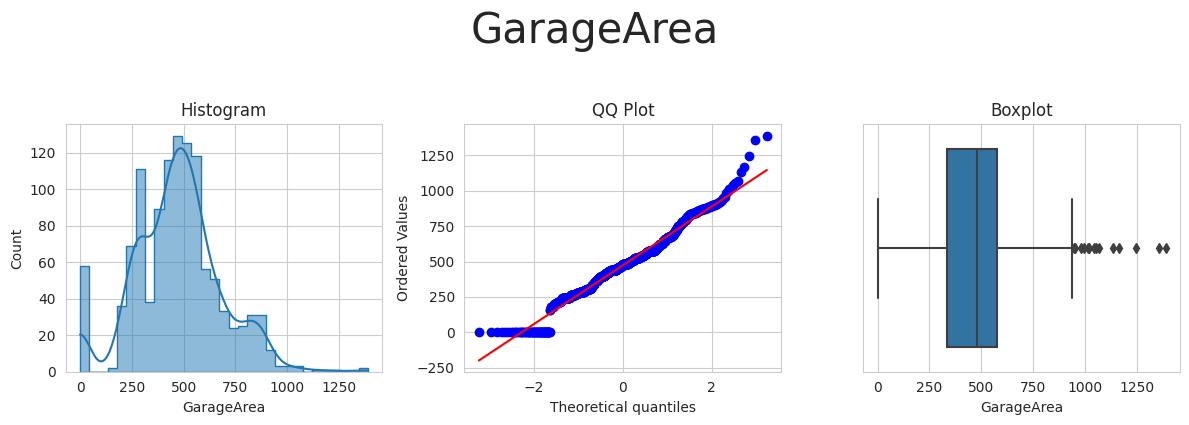

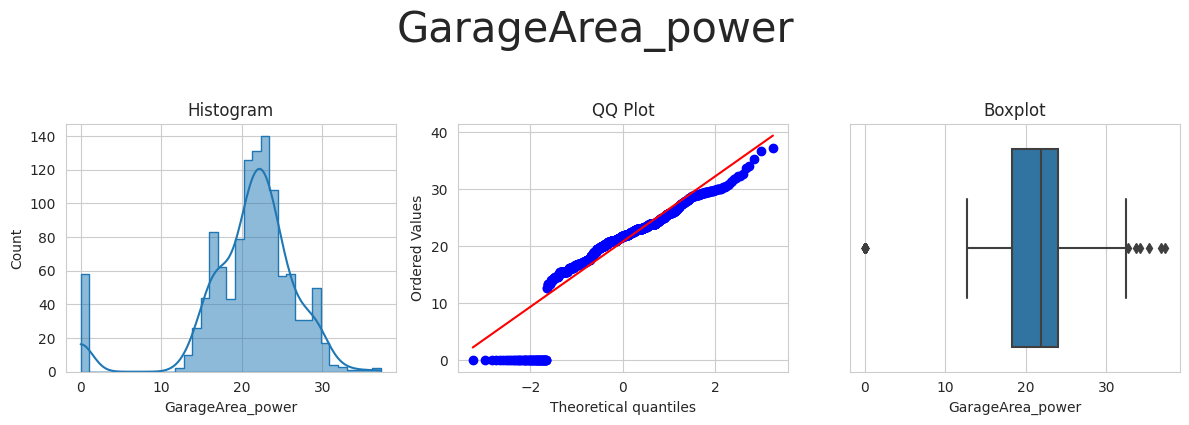

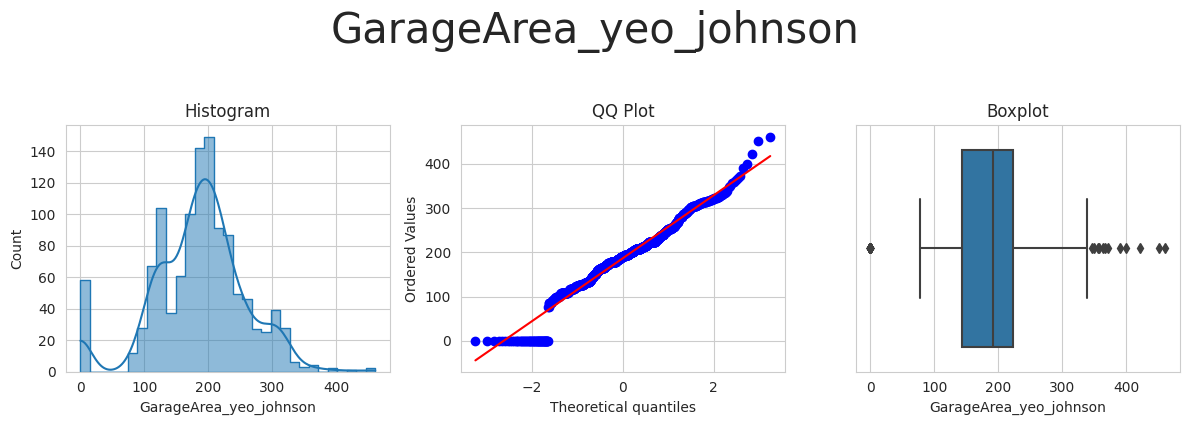



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



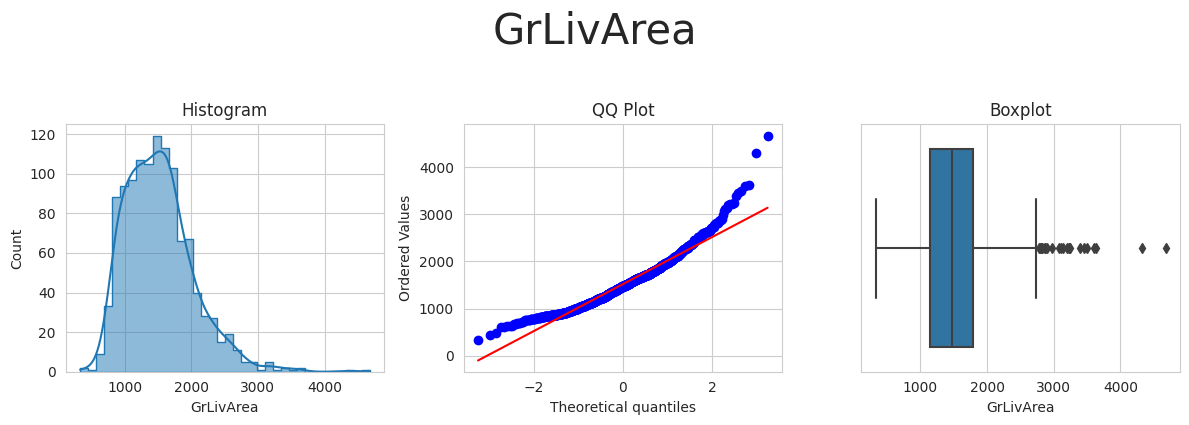

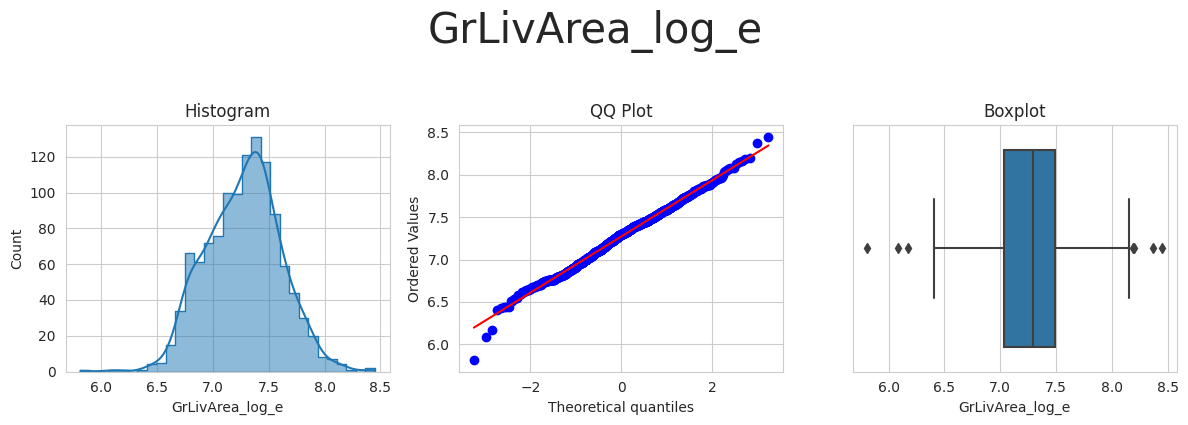

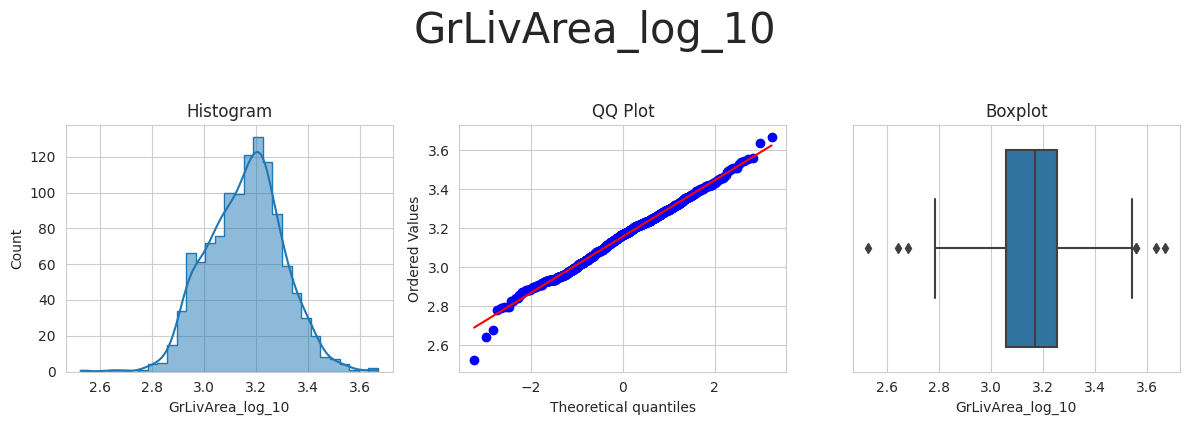

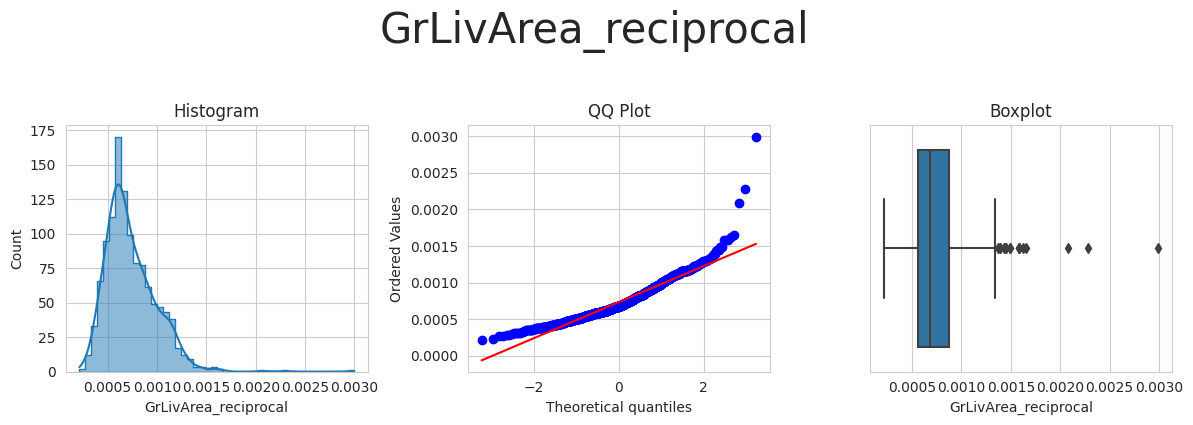

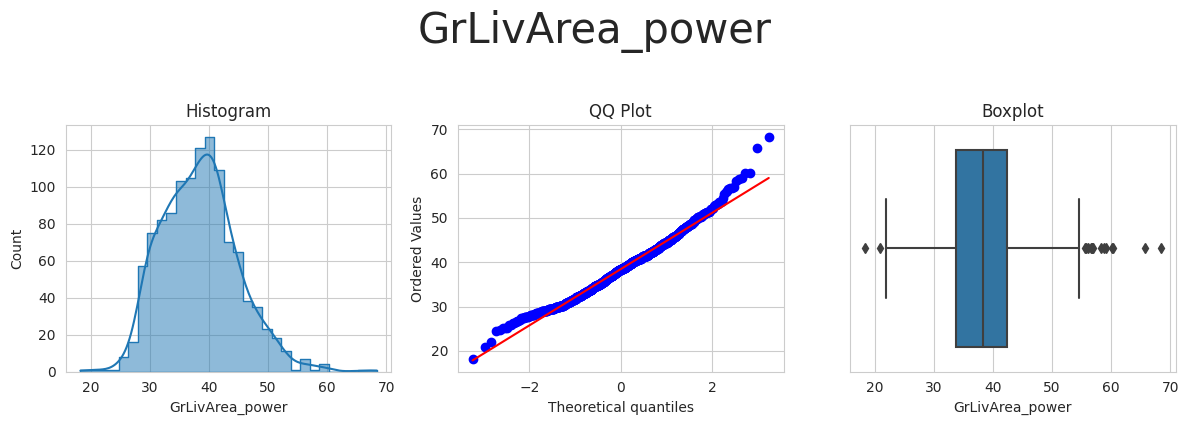

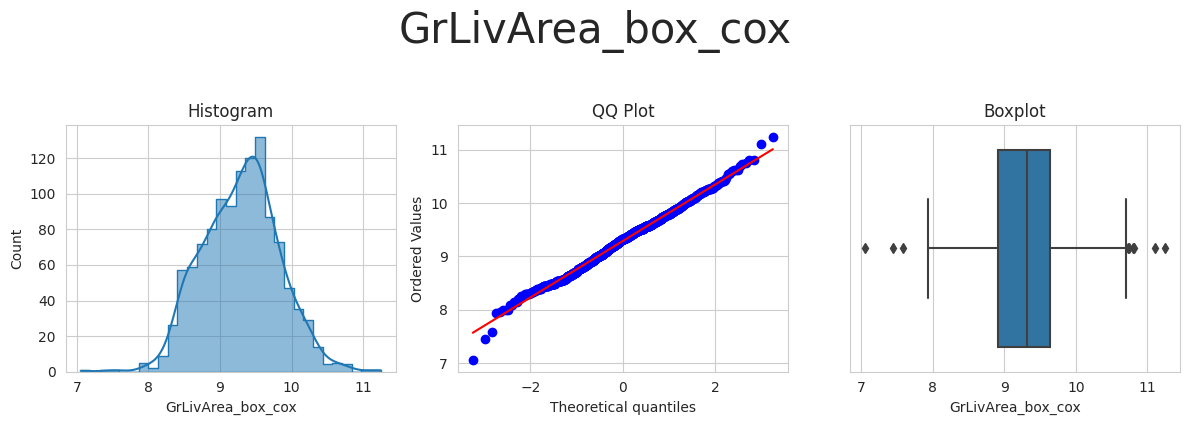

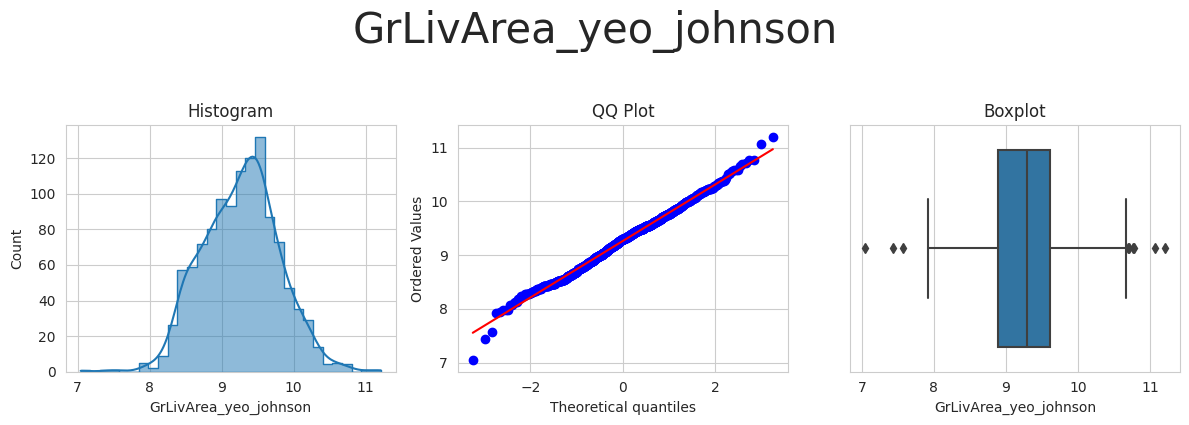



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



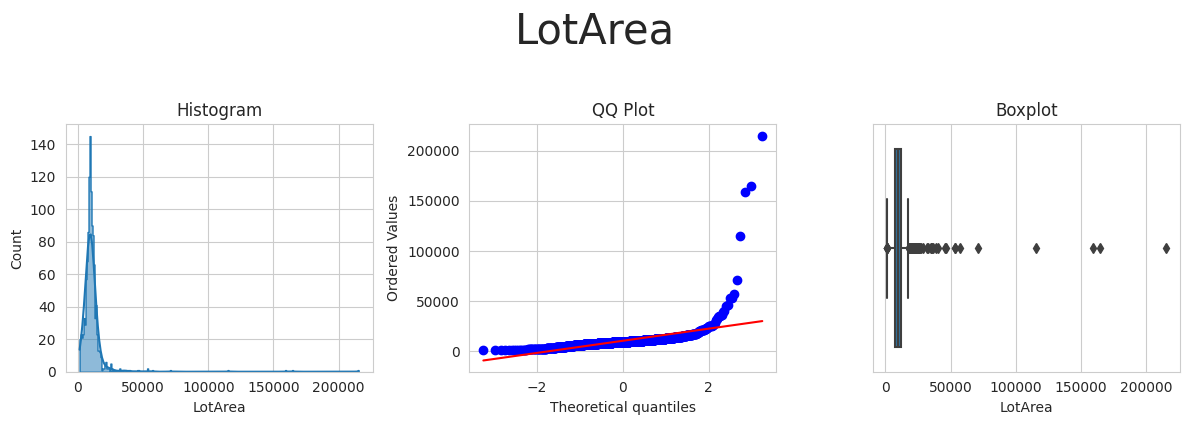

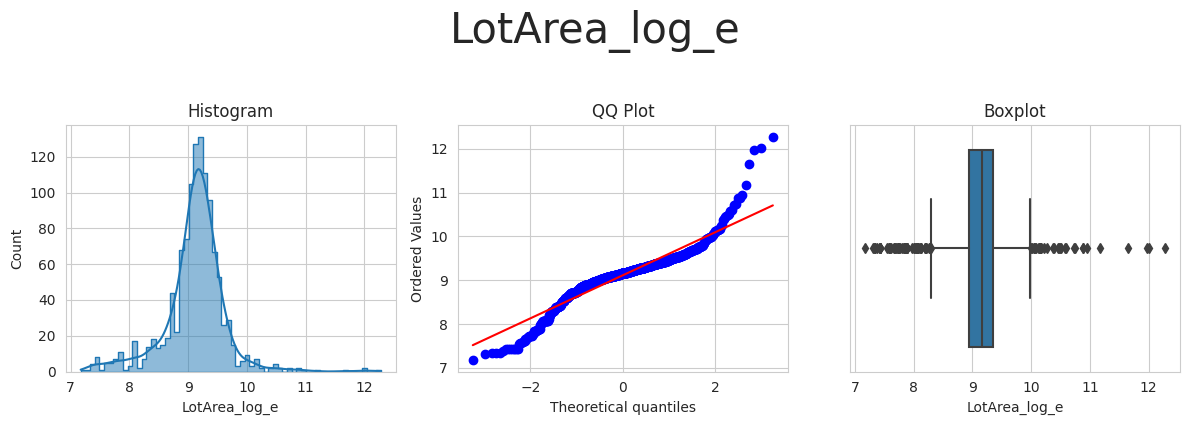

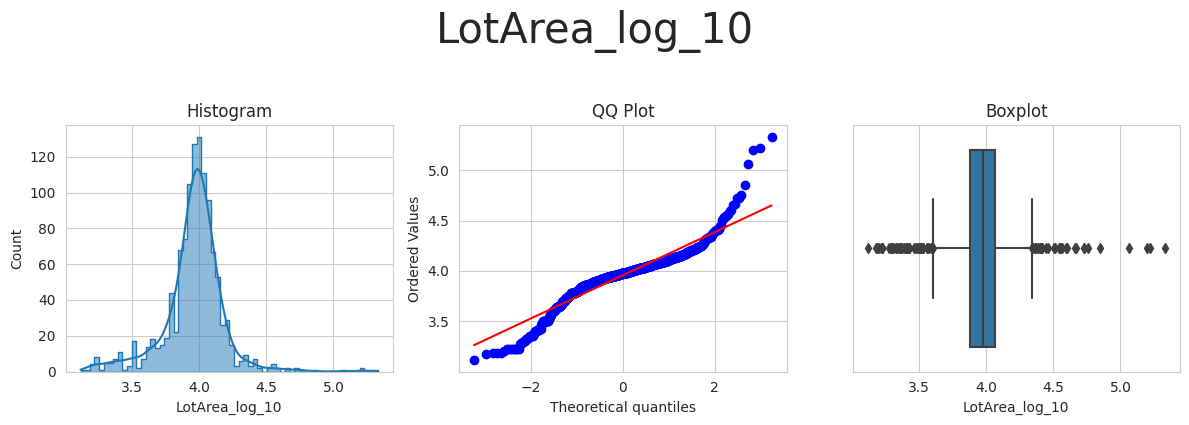

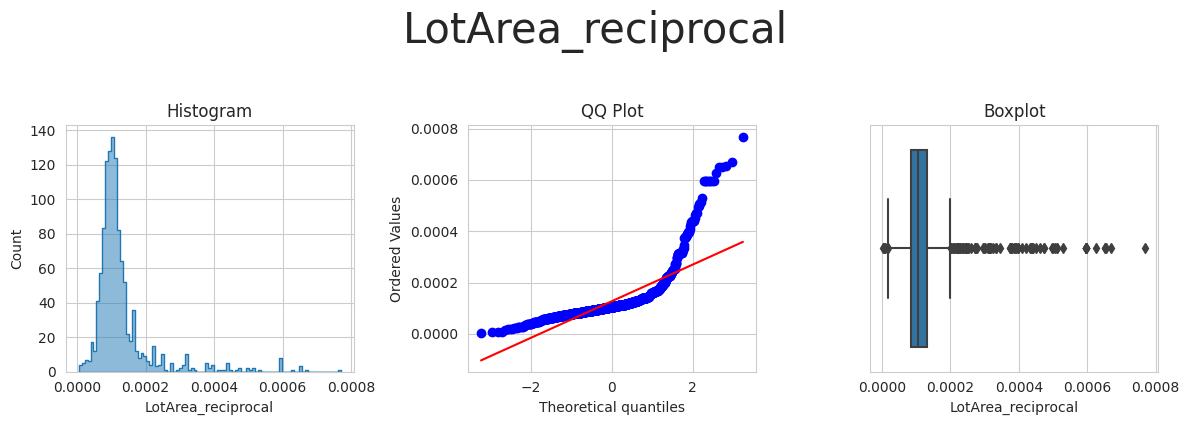

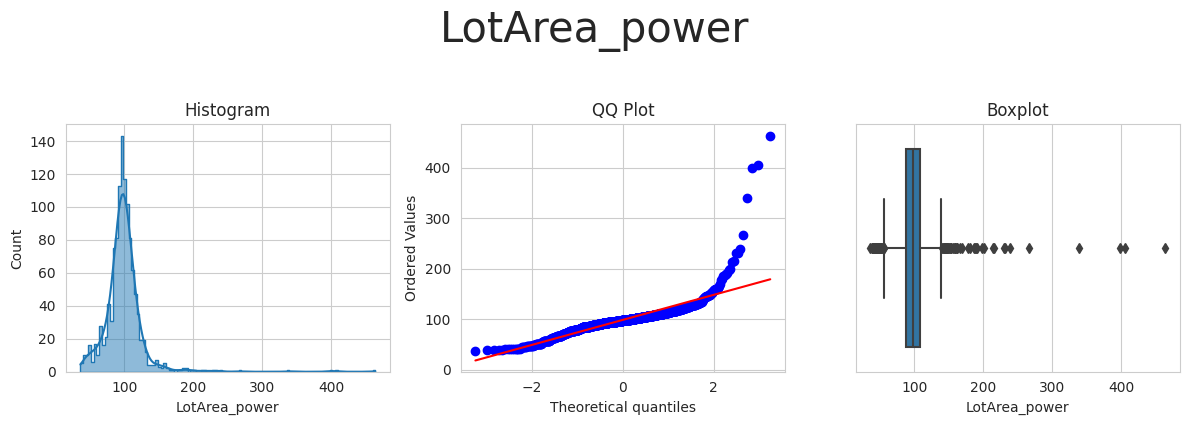

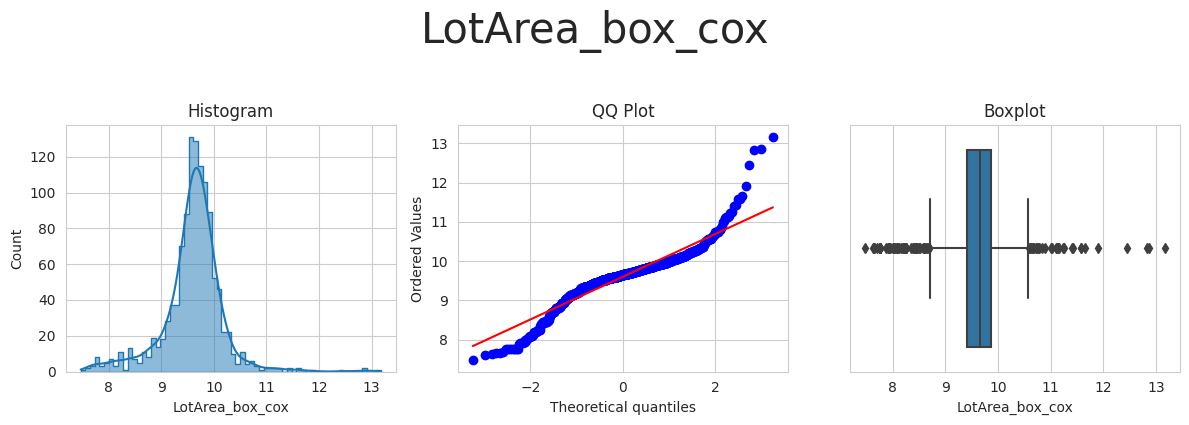

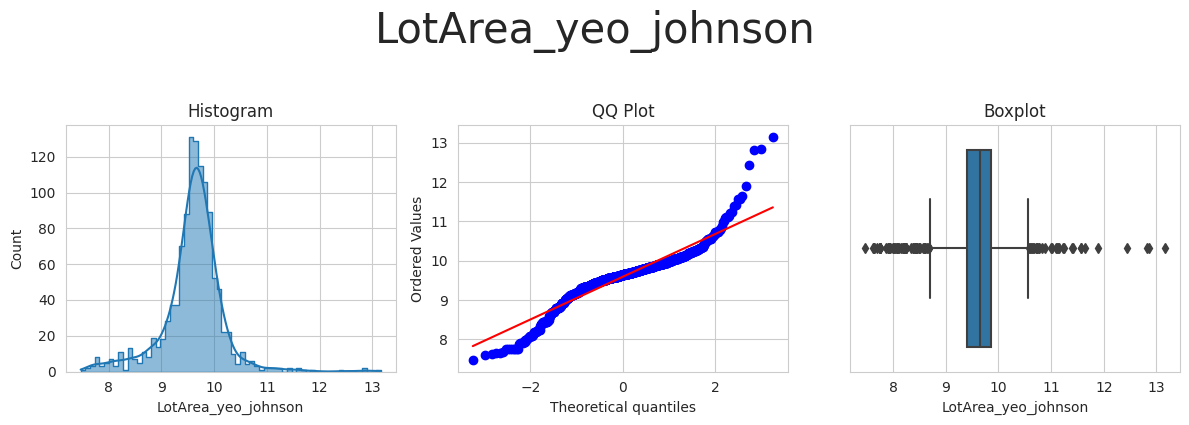



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



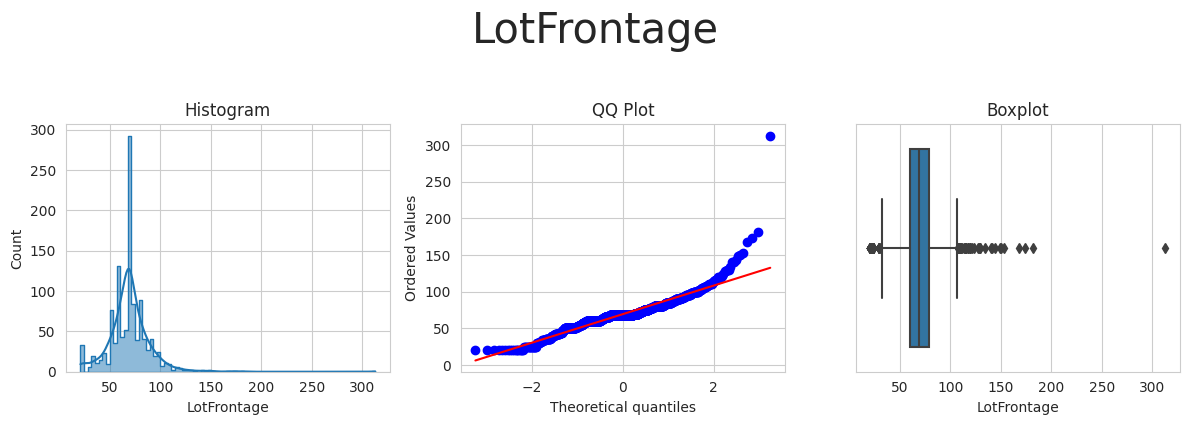

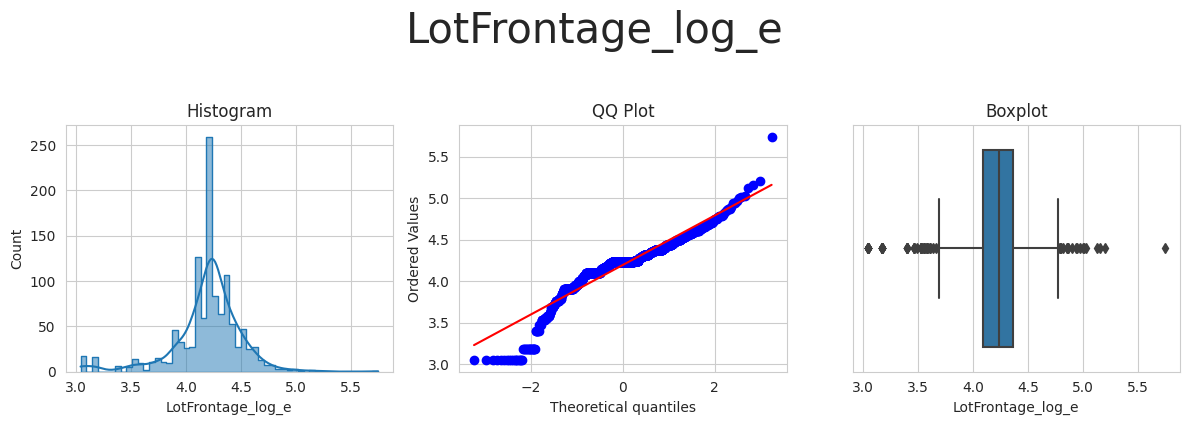

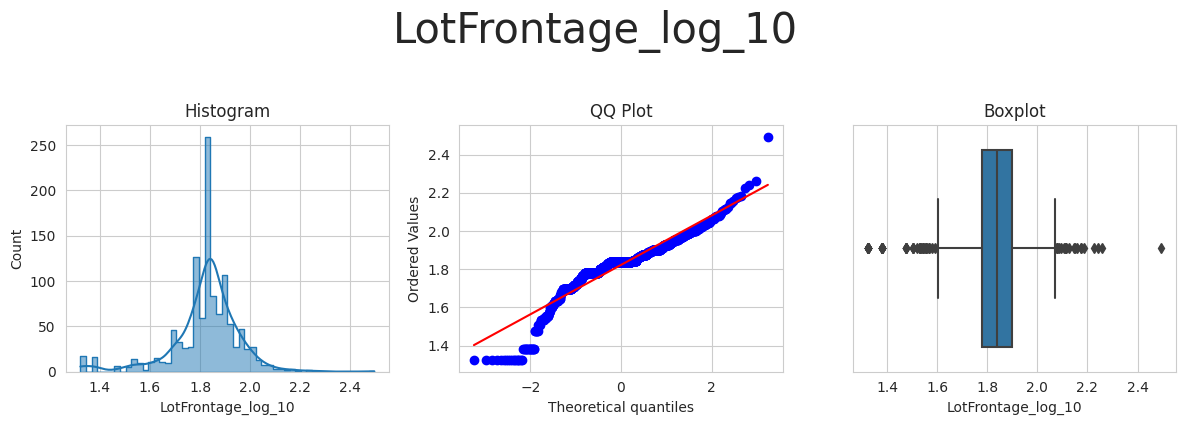

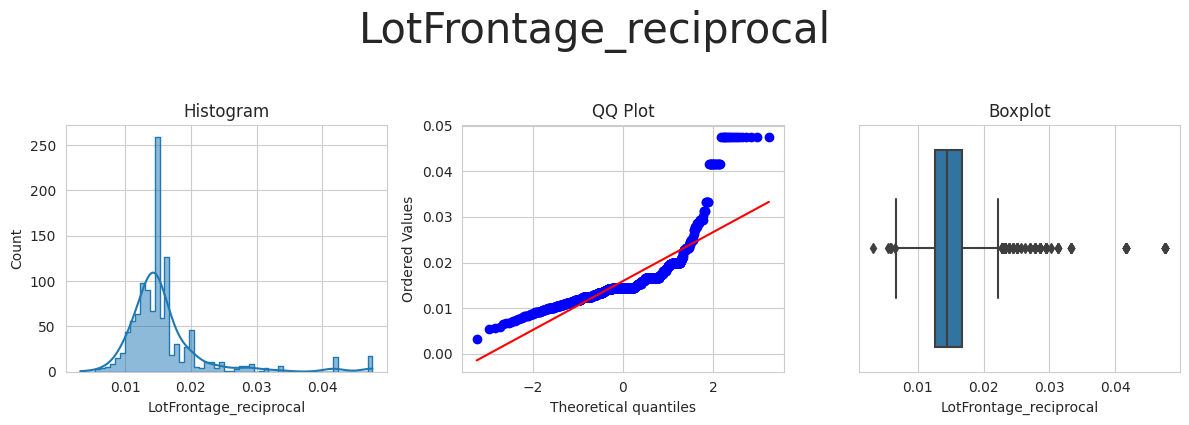

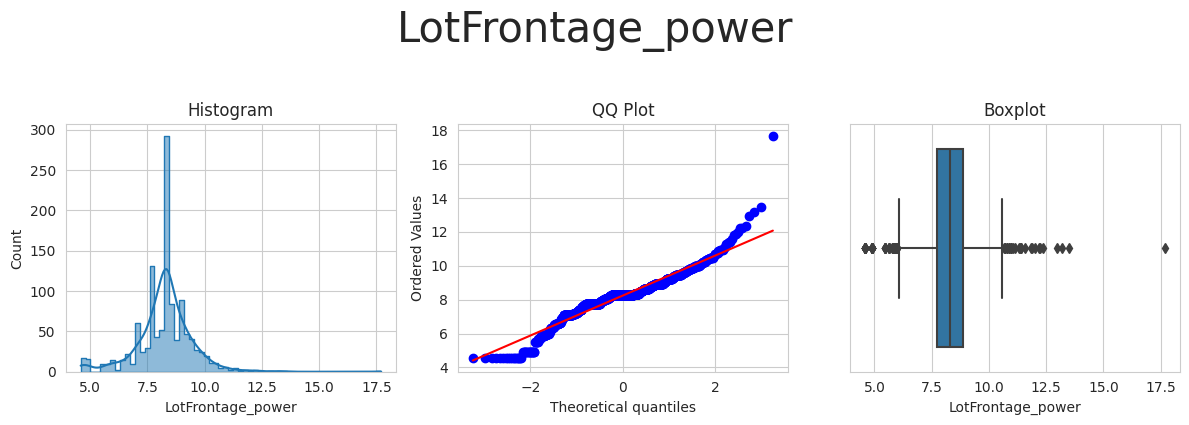

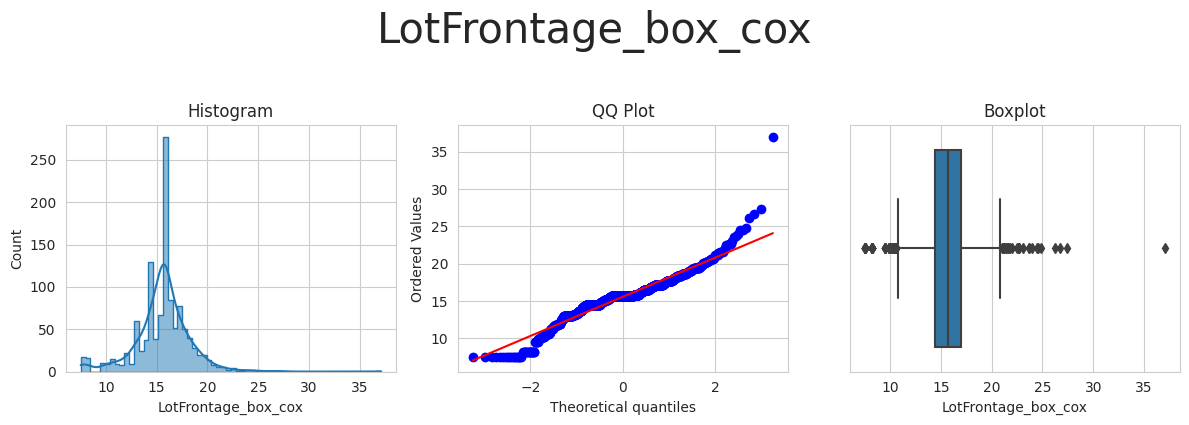

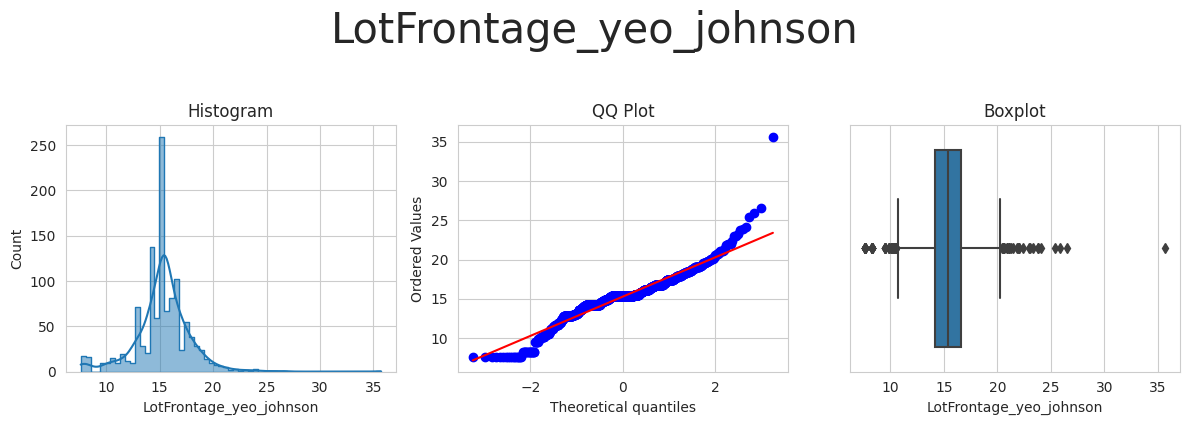



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_power', 'MasVnrArea_yeo_johnson'] 



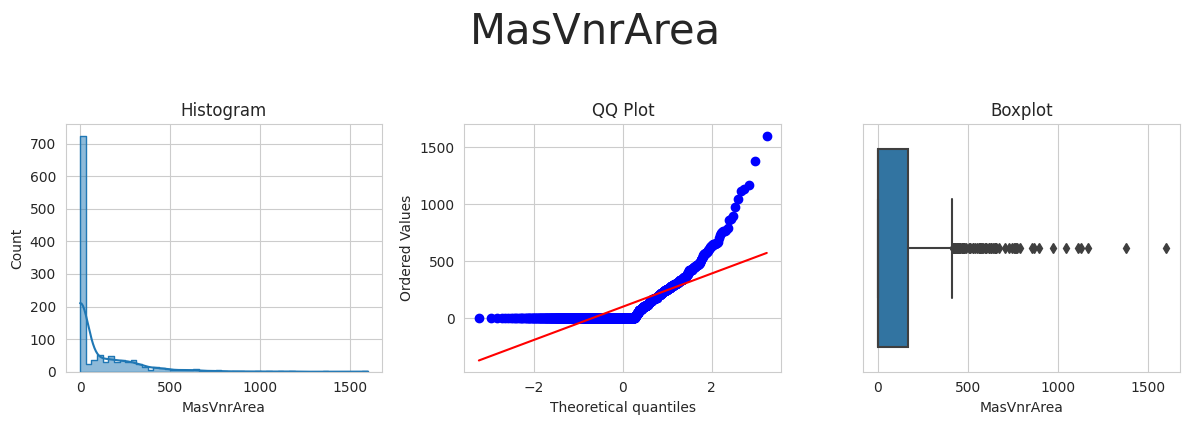

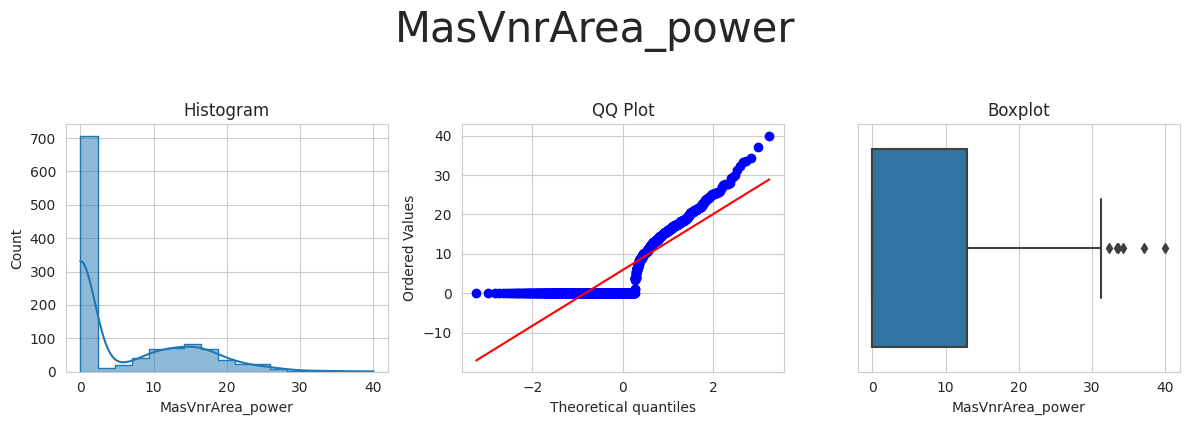

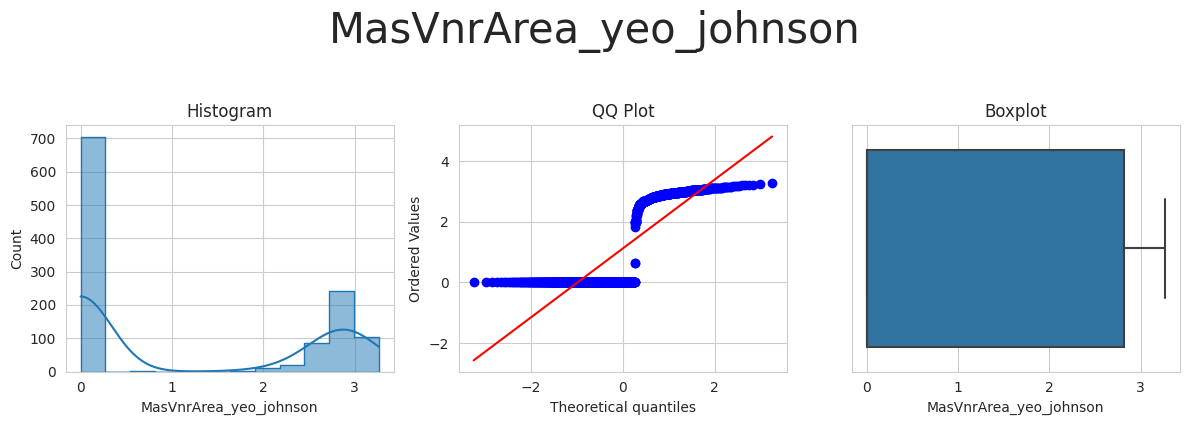



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_power', 'OpenPorchSF_yeo_johnson'] 



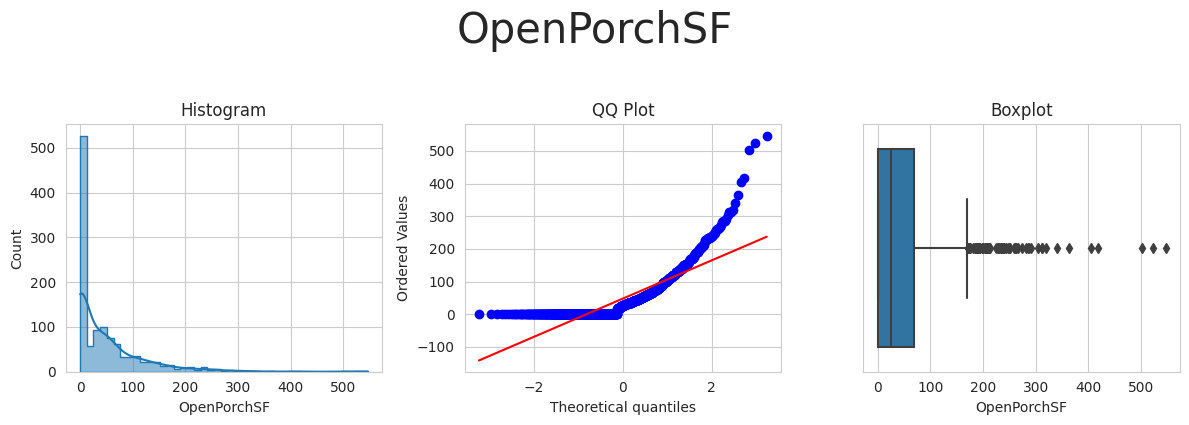

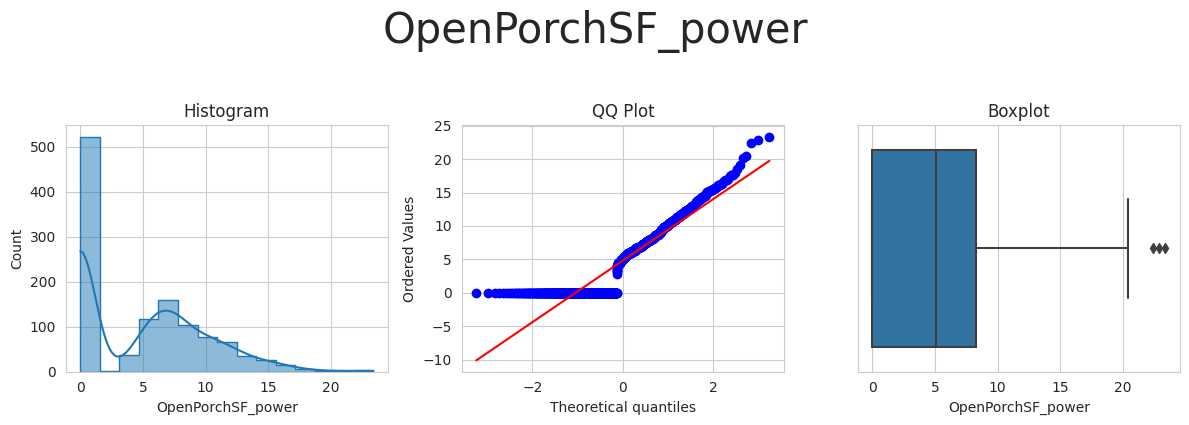

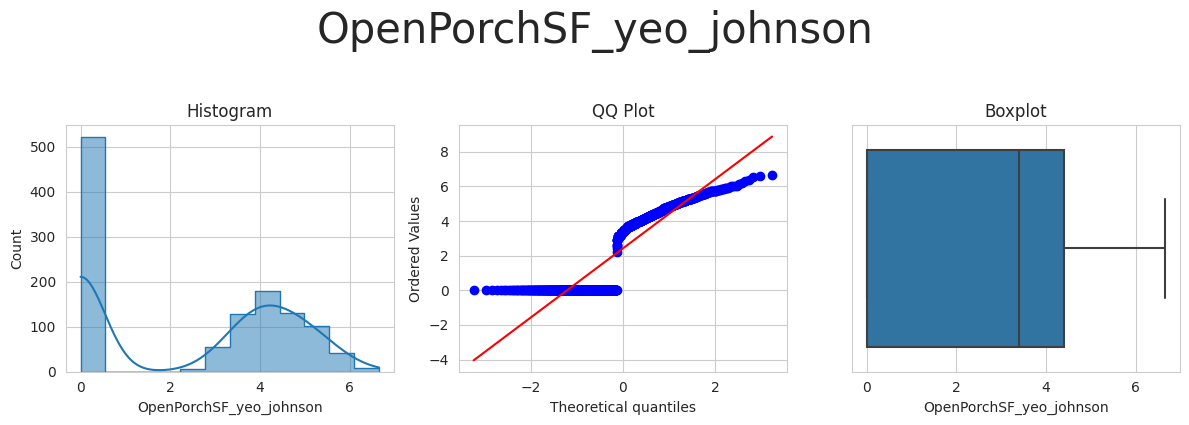



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



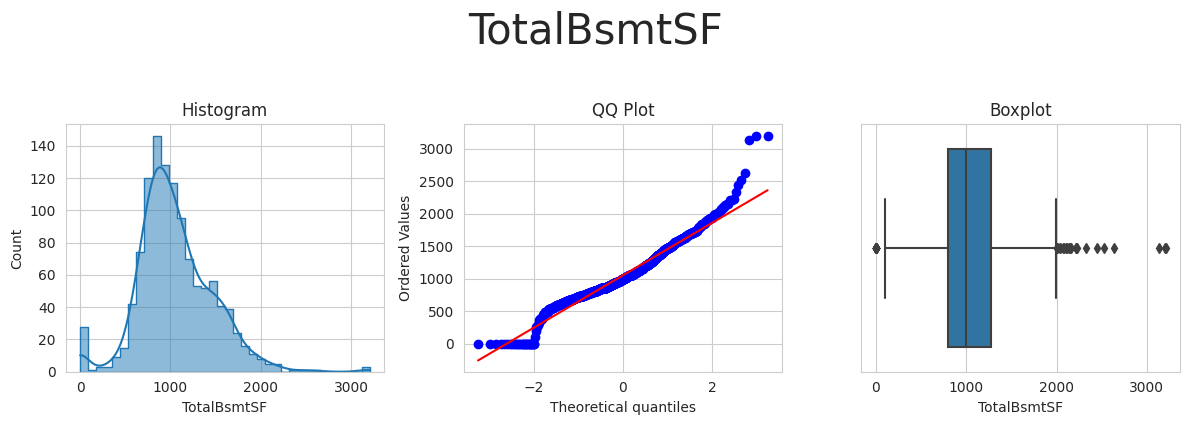

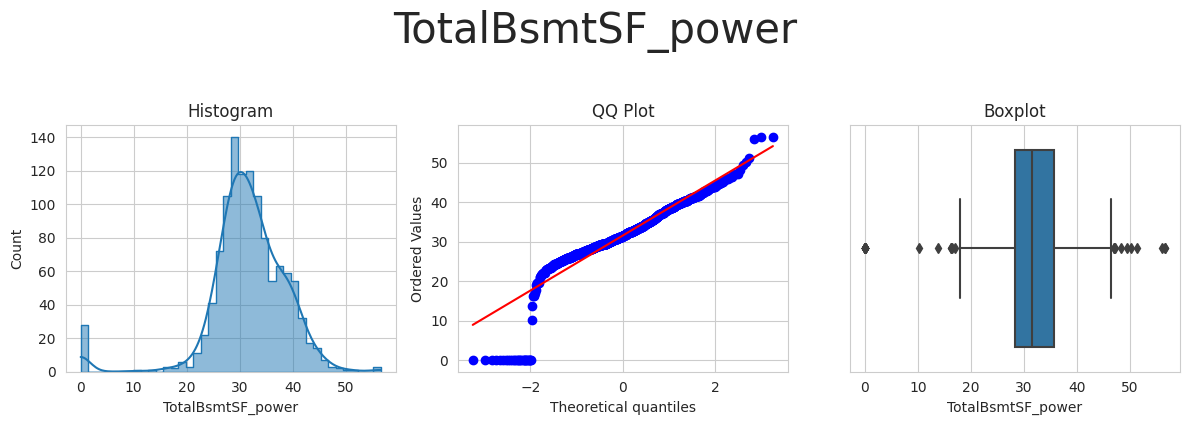

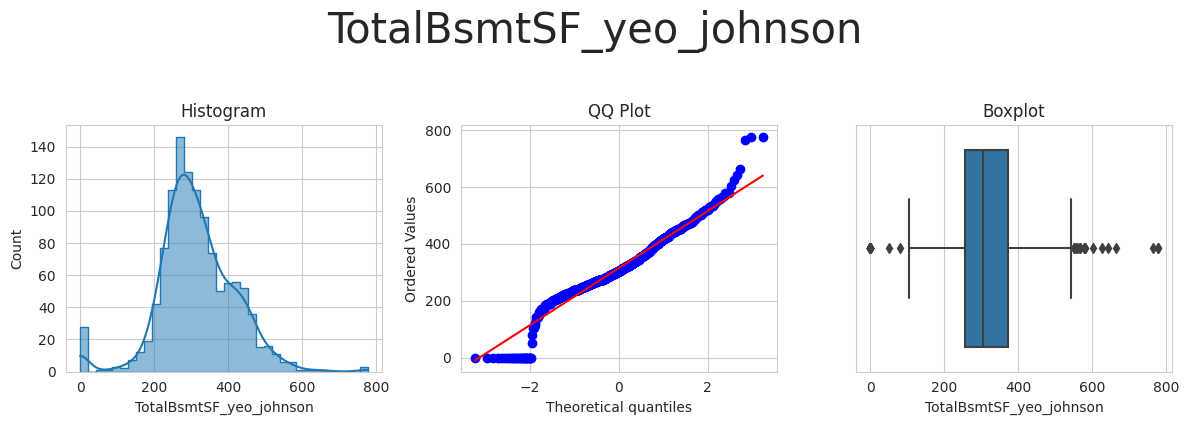

In [18]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering,
                                            analysis_type='numerical')

Conclusion:

**1stFlrSF** - Log_e, Log_10, Power, Box Cox and Yeo Johnson all visually improved the distribution on the histogram. I chose to use the `Log_10 Transformer` as this transformation specialises in correcting positive skewness.

**2ndFlrSF** - There was not much improvement in the distribution on the histogram or the alignment to the normal distribution on the QQ plot. `No Transformation` was selected for this feature.

**BsmtFinSF1** - There was not much improvement in the distribution on the histogram or the alignment to the normal distribution on the QQ plot. `No Transformation` was selected for this feature.

**BsmtUnfSF** - Power and Yeo_Johnson both visually improved the distribution on the histogram, but had limited changed to the alignment to the normal distribution on the QQ plot. I chose to use a `Power Transformer` on this feature as this is also a good transformer when dealing with a high amount of zeros, and due to all the data being positive, I dont need to flexibility of the Yeo Johnson Transformer.  

**GarageArea** - Power and Yeo_Johnson visually improved the distribution on the histogram, but Yeo_Johnson had a better transformation on the QQ plot, aligning the data with the normal distribution better. I chose to use the `Yeo_Johnson Transformer` on this feature. 

**GrLivArea** - Log_e, Log_10, Box Cox and Yeo Johnson all visually improved the distribution on the histogram and the alignment to the normal distribution on the QQ plot. I chose to use the `Log_10 Transformer`.

**LotArea** - Box Cox visually improved the distribution on the histogram and a slight improvement in the alignment to the normal distribution on the QQ plot. I chose to use the `Box_Cox Transformer`.

**LotFrontage** - Log_10 visually improved the distribution on the histogram, but did not make the alignment to the normal distribution any better. Likely due to outliers as shown in the box plot. I chose to use the `Log_10 Transformer`.

**MasVnrArea** - There was not much improvement in the distribution on the histogram or the alignment to the normal distribution on the QQ plot. `No Transformation` was selected for this feature. 

**OpenPorchSF** - There was not much improvement in the distribution on the histogram or the alignment to the normal distribution on the QQ plot. `No Transformation` was selected for this feature.

**TotalBsmtSF** - Yeo_Johnson visually improved the distribution on the histogram. I chose to use the `Yeo_Johnson Transformer` on this feature.

Step 4: Apply the selected transformation to the Train and Test set

In [19]:
# This is completed at the bottom of the workbook in one pipeline

### SmartCorrelatedSelection variables

Step 1: Select the variable(s)

In [20]:
# I will be applying this feature engineering step to all of the variables

Step 2: Create a separate DataFrame, with your variable(s)

In [21]:
df_engineering = TrainSet.copy()
df_engineering.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      1828       0.0      2.883272           Av          48          Unf   
1       894       0.0      2.000000           No           0          Unf   
2       964       0.0      2.000000           No         713          ALQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0       1774         774          Unf       2007.0  ...    11694        90.0   
1        894         308          Unf       1962.0  ...     6600        60.0   
2        163         432          Unf       1921.0  ...    13360        80.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0       452.0          108            5            9         1822       2007   
1         0.0            0            5            5          894       1962   
2         0.0            0            7            5          876       1921   

   YearRemodAdd  SalePrice  
0          2007     314813  
1          1962     109500  
2          2006     163500  

[3 rows x 22 columns]

Step 3: Create engineered variables(s) applying the transformation(s)

In [22]:
corr_sel = SmartCorrelatedSelection(variables=None,
                                    method="spearman",
                                    threshold=0.6,
                                    selection_method="variance"
                                    )

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

[{'1stFlrSF', 'TotalBsmtSF'},
 {'2ndFlrSF', 'GrLivArea'},
 {'GarageArea', 'SalePrice'},
 {'GarageYrBlt', 'YearBuilt', 'YearRemodAdd'}]

In [23]:
corr_sel.features_to_drop_

['1stFlrSF', '2ndFlrSF', 'GarageArea', 'GarageYrBlt', 'YearRemodAdd']

## Sklearn Feature Engineering Transformation Pipelie

In [24]:
feature_engineering_pipeline = Pipeline([
    ('ordinal_encoder', OrdinalEncoder(encoding_method='arbitrary',
                                       variables=['BsmtExposure',
                                                  'BsmtFinType1',
                                                  'GarageFinish',
                                                  'KitchenQual'])),
    ('outlier_winsorizer', Winsorizer(capping_method='iqr',
                                      tail='both',
                                      fold=1.5,
                                      variables=[
                                          '1stFlrSF',
                                          '2ndFlrSF',
                                          'BsmtFinSF1',
                                          'BsmtUnfSF',
                                          'GarageArea',
                                          'GrLivArea',
                                          'LotArea',
                                          'LotFrontage',
                                          'MasVnrArea',
                                          'OpenPorchSF',
                                          'TotalBsmtSF'])),
    ('log_10', vt.LogTransformer(variables=[
                                        '1stFlrSF',
                                        'GrLivArea',
                                        'LotFrontage'], base='10')),
    ('power', vt.PowerTransformer(variables=['BsmtUnfSF'])),
    ('yeo_johnson', vt.YeoJohnsonTransformer(variables=[
                                                    'GarageArea',
                                                    'TotalBsmtSF'])),
    ('box_cox', vt.BoxCoxTransformer(variables=['LotArea'])),
    ('smart_correlated_selection', SmartCorrelatedSelection(variables=None,
                                                            method="spearman",
                                                            threshold=0.6,
                                                            selection_method="variance"))
])

TrainSet, TestSet = feature_engineering_pipeline.fit_transform(TrainSet), feature_engineering_pipeline.fit_transform(TestSet)

## Conclusion

The following steps will be added to the ML Pipeline

* Feature Engineering Transformers
  * Ordinal Categorical Encoding: `['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']`
  * Outlier Winsorizer: `['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF']`
  * Numerical Transformation:
    * Log Transformer (10): `['1stFlrSF', 'GrLivArea', 'LotFrontage']` 
    * Power Transformer: `['BsmtUnfSF']`
    * Yeo Johnson Transformer: `['GarageArea','TotalBsmtSF']`
    * Box Cox Transformer: `['LotArea']`
  * Smart Correlated Selection: `All Features`